# Shifted Beta-Geometric Model with Cohorts and Covariates

The Shifted Beta-Geometric (sBG) model was first introduced in ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader in 2007, and is ideal for predicting customer behavior in business cases involving contract renewals or recurring subscriptions. In this notebook we will reproduce the research results with the cohort and covariate functionality of PyMC-Marketing, then proceed to an end-to-end example with EDA and additional predictive methods. 

## Setup Notebook

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [197]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams['figure.constrained_layout.use'] = False

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed = sum(map(ord, "sBG Model"))
rng = np.random.default_rng(seed)

## Load Data

Data must be aggregrated in the following format for model fitting:

- `customer_id` is an index of unique identifiers for each customer
- `recency` indicates the most recent time period a customer was still active
- `T` is the maximum observed time period for a given cohort
- `cohort` indicates the cohort assignment for each customer

For active customers, `recency` is equal to `T`, and all customers in a given cohort share the same value for `T`. If a customer cancelled their contract and restarted at a later date, a new `customer_id` must be assigned for the restart.

Sample data is available in the PyMC-Marketing repo. To see the code used to generate this data, refer to `generate_sbg_data` in `scripts/clv_data_generation.py`.

In [4]:
cohort_df = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_cohorts.csv")
cohort_df

customer_id  recency  T   cohort
0               1        1  8  highend
1               2        1  8  highend
2               3        1  8  highend
3               4        1  8  highend
4               5        1  8  highend
...           ...      ... ..      ...
1995         1996        8  8  regular
1996         1997        8  8  regular
1997         1998        8  8  regular
1998         1999        8  8  regular
1999         2000        8  8  regular

[2000 rows x 4 columns]

This dataset was generated from the first 8 time periods in Table 1 of the research paper, which provides survival rates for two customer cohorts ("Regular" and "Highend") over 13 time periods:

In [218]:
# Data from research paper
research_data = pd.DataFrame(
    {
        "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
        "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
    }
)
research_data

regular  highend
0     100.0    100.0
1      63.1     86.9
2      46.8     74.3
3      38.2     65.3
4      32.6     59.3
5      28.9     55.1
6      26.2     51.7
7      24.1     49.1
8      22.3     46.8
9      20.7     44.5
10     19.4     42.7
11     18.3     40.9
12     17.3     39.4

This is also a useful format for model evaluation. In survival analysis parlance, customers with `recency==T` are "right-censored". If we fit a model to the first 8 time periods, we can test predictions on censored data over the remaining 5 periods.

In [6]:
# Utility function to aggregate model fit data for evaluation
def survival_rate_aggregation(customer_df: pd.DataFrame):
    """Aggregate customer-level sBG data into survival rates by cohort over time."""
    # Group by cohort to get total counts
    cohort_totals = customer_df.groupby('cohort')['customer_id'].count()
    cohorts = customer_df["cohort"].unique()
    
    # Create a list to store results for each time period
    results = []
    
    # For each time period from 0 to T (8 in this case)
    for t in range(customer_df['T'].max()):
        row_data = {'T': t}
    
        for cohort in cohorts:
            cohort_data = customer_df[customer_df['cohort'] == cohort]
            total_customers = len(cohort_data)
    
            if t == 0:
                # At time 0, 100% retention
                retention_pct = 100.0
            else:
                # Count customers who survived at least to time t (recency >= t)
                survived = len(cohort_data[cohort_data['recency'] > t])
                retention_pct = (survived / total_customers) * 100
    
            row_data[cohort] = retention_pct
    
        results.append(row_data)

    return pd.DataFrame(results)

# Aggregate model fit data
df_actual = survival_rate_aggregation(cohort_df)

# Assign T column to research data and truncate to 8 periods
research_data["T"] = research_data.index
df_expected = research_data[["T","highend","regular"]].query("T<8").copy()

# Assert aggregated dataset is equivalent to the values in the research paper
pd.testing.assert_frame_equal(df_actual,df_expected)

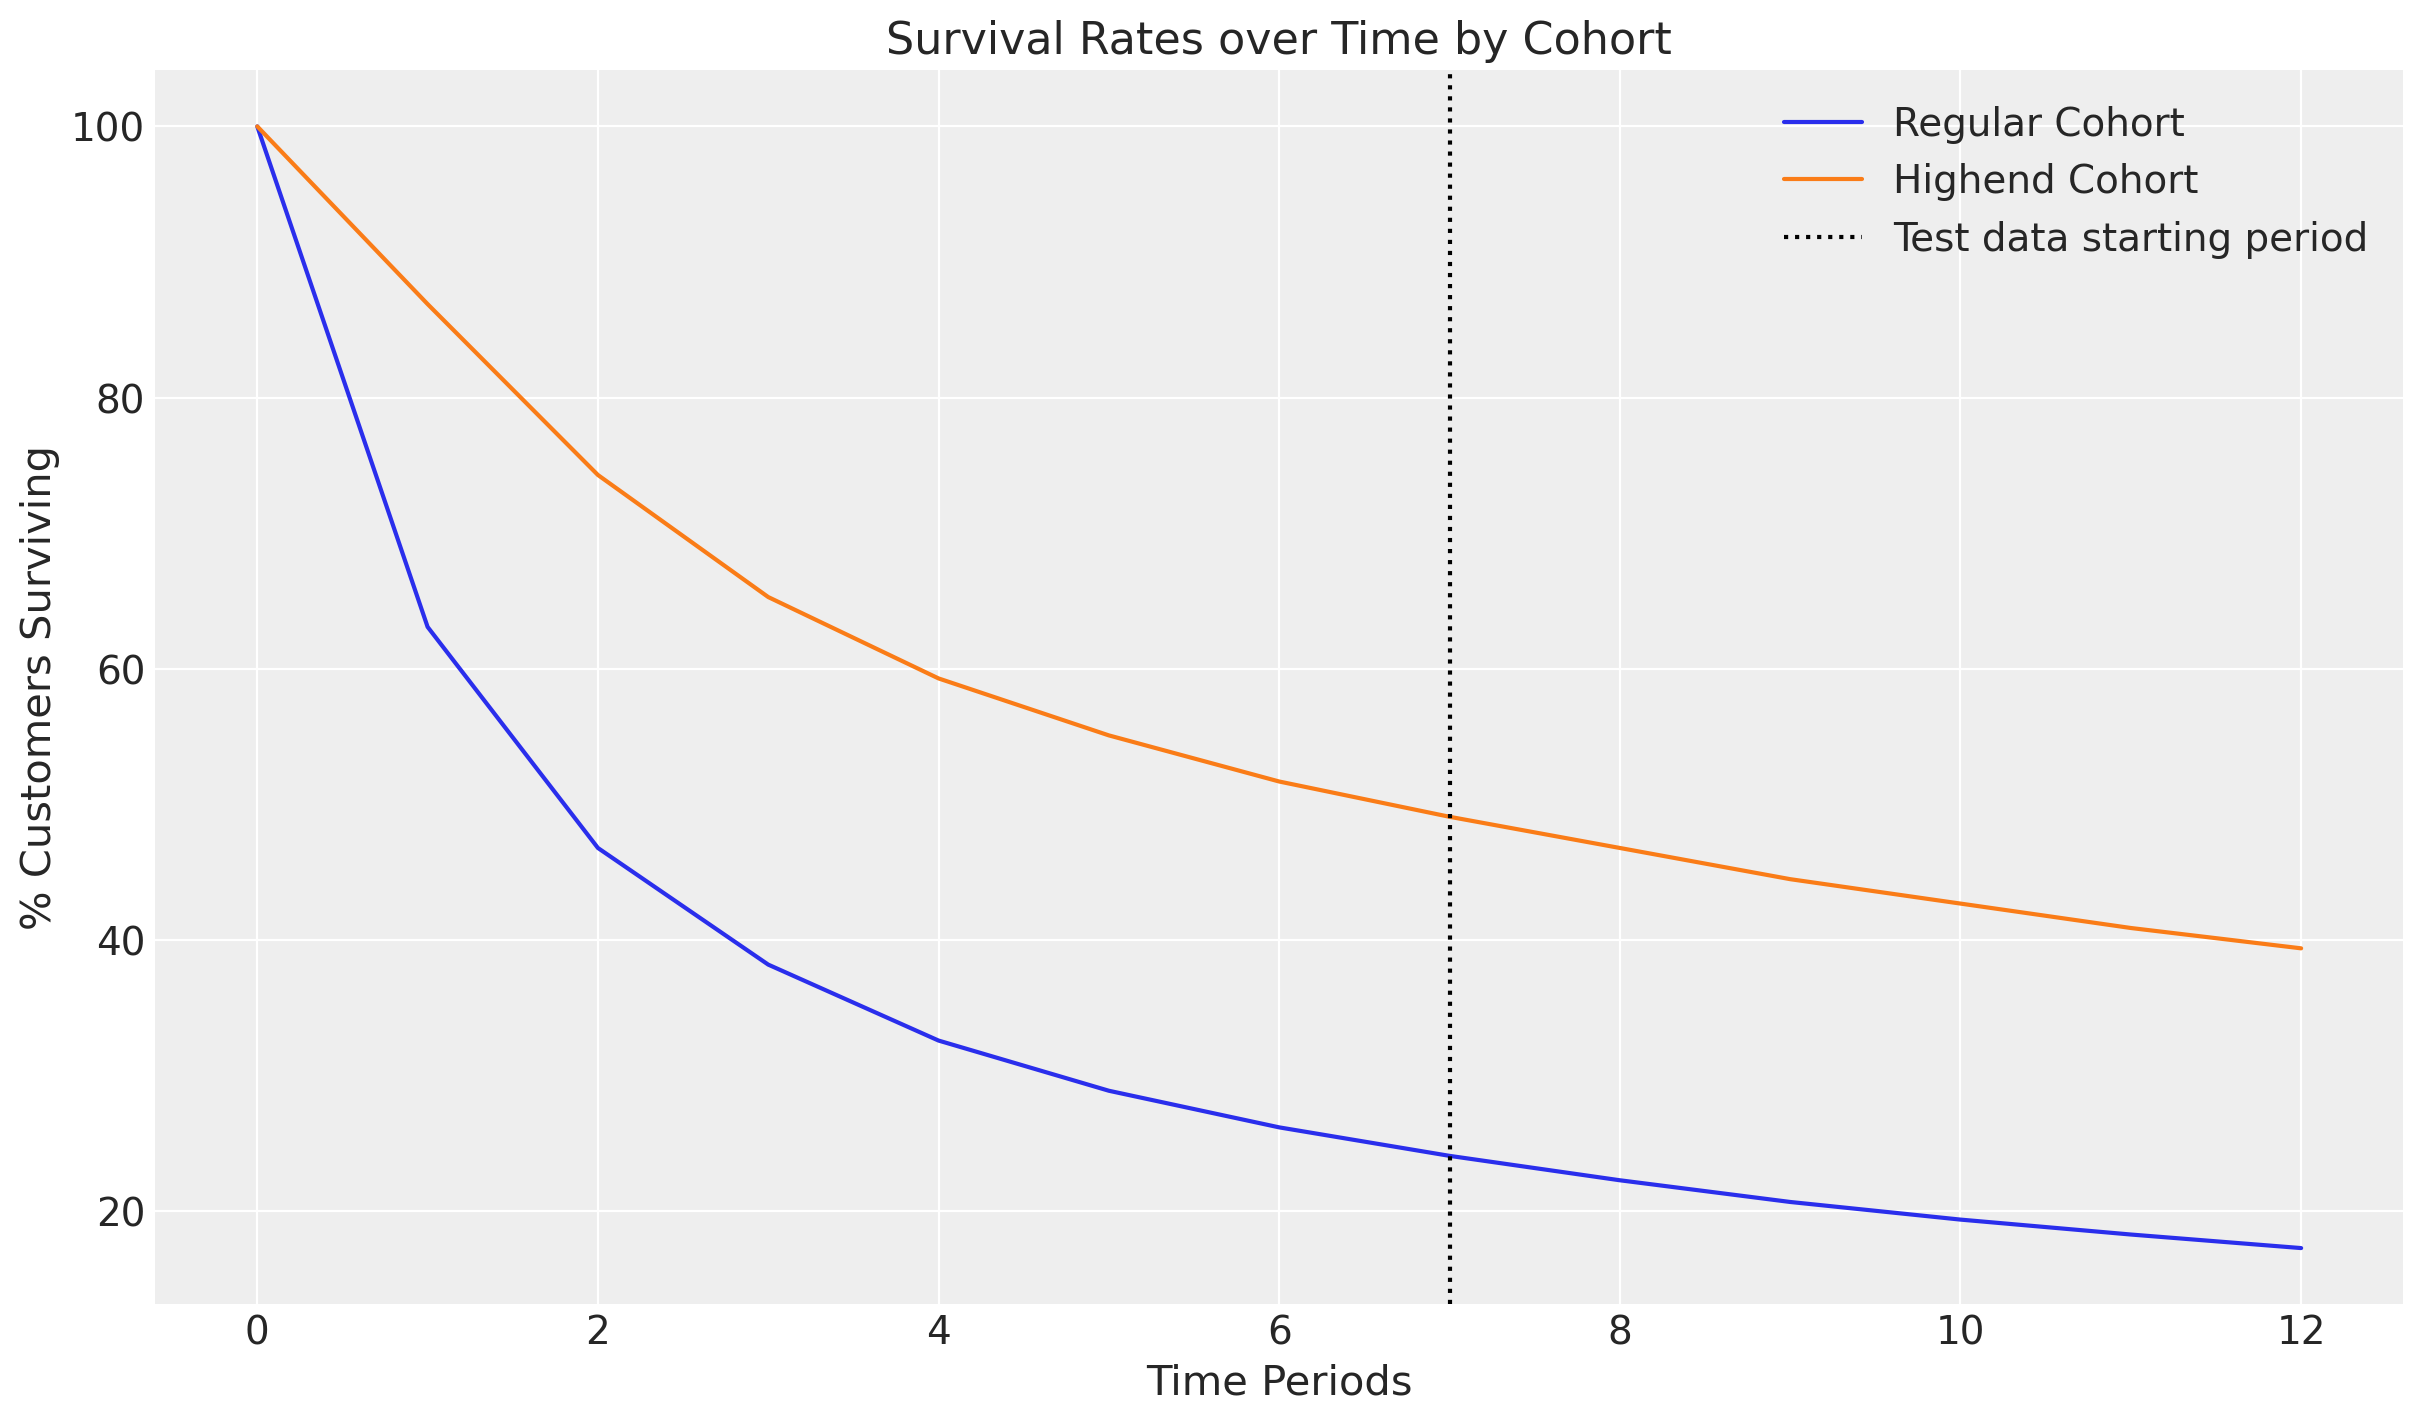

In [7]:
plt.plot(research_data["regular"].values, label="Regular Cohort")
plt.plot(research_data["highend"].values, label="Highend Cohort")
plt.ylabel("% Customers Surviving")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.title("Survival Rates over Time by Cohort");

Let's proceed to the modeling step.

# Basic Model Fitting

The sBG model has the following assumptions:

1. Individual customer lifetime durations are characterized by the (shifted) Geometric distribution, with cancellation probability $\theta$.
2. Heterogeneity in $\theta$ follows a Beta distribution with shape parameters $\alpha$ and $\beta$.

If we take the expectation across the distribution of $\theta$, we can derive a likelihood function to estimate parameters $\alpha$ and $\beta$ for the customer population. For more details on the `ShiftedBetaGeometric` mixture distribution, please refer to the [documentation](https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.clv.distributions.ShiftedBetaGeometric.html#pymc_marketing.clv.distributions.ShiftedBetaGeometric).

The original frequentist model assumes a single cohort of customers who all started their contracts in the same time period. This requires fitting a separate model for each cohort. However, in PyMC-Marketing we can fit all cohorts in a single hierarchical Bayesian model!

Here are the parameter estimates from the research paper for a sBG model fit with Maximum Likelihood Estimation (MLE) and the provided data:

In [59]:
# MLE estimates from the paper
mle_research_parameters = {
    #"cohort": [alpha, beta]
    "regular": [0.704, 1.182],
    "highend": [0.668, 3.806],
}

## Reproduce Research Results with Cohorts

### Model Fitting with MAP

The Bayesian equivalent of a frequentist MLE fit is Maximum a Posteriori (MAP) with "flat" priors. A flat prior can be used when the user is agnostic about the observed data, holding no prior beliefs or assumptions. Since $\alpha$ and $\beta$ must be positive values, let's configure our Bayesian `ShiftedBetaGeoModel` with `HalfFlat` priors:

In [9]:
sbg_map = clv.ShiftedBetaGeoModel(
    data = cohort_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims = "cohort"),
        "beta": Prior("HalfFlat", dims = "cohort"),
    }
)
sbg_map.fit(method="map")
sbg_map.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

MAP parameter estimates are identical to those in the research! However, this is also a simple benchmarking dataset with only two cohorts. HalfFlat priors are slow to converge and can be unstable in practice because no regularization is applied to model parameters during fitting. MAP fits also do not provide credibility intervals for model predictions.

The ability to regularize parameter estimates with prior distributions derived from our domain knowledge is a big advantage of the Bayesian approach. With full Bayesian sampling we can infer the posterior probability distributions for these parameters, illustrating uncertainty in our estimates as well as generating prediction intervals.

### Model Fitting with MCMC

The default sampler in PyMC-Marketing is the No-U-Turn Sampler (NUTS), which samples from the posterior by exploring the gradients of the probability space. The default prior configuration for `ShiftedBetaGeoModel` works well for many use cases:

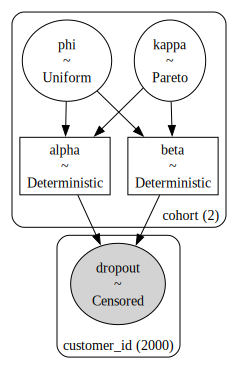

In [10]:
sbg_mcmc = clv.ShiftedBetaGeoModel(data=cohort_df)
sbg_mcmc.build_model() # optional step to view modeling Priors and running prior predictive checks
sbg_mcmc.graphviz()

The default `kappa` and `phi` priors are pooling distributions that improve the speed & reliability of model fits, but can be omitted by specifying a custom `model_config` for `alpha` and `beta`. Note the number of cohorts is also provided and the dropout $\theta$ distribution is censored just like the dataset.

Let's fit a MCMC model and visualize the results:

In [11]:
sbg_mcmc.fit(method='mcmc')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [12]:
sbg_mcmc.fit_summary(var_names=["alpha","beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[highend]  0.669  0.106   0.491    0.872      0.002    0.002    2841.0   
alpha[regular]  0.703  0.066   0.582    0.821      0.001    0.001    3000.0   
beta[highend]   3.809  0.807   2.366    5.232      0.017    0.016    2342.0   
beta[regular]   1.183  0.155   0.905    1.473      0.003    0.003    2179.0   

                ess_tail  r_hat  
alpha[highend]    2945.0    1.0  
alpha[regular]    2232.0    1.0  
beta[highend]     2482.0    1.0  
beta[regular]     2251.0    1.0

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

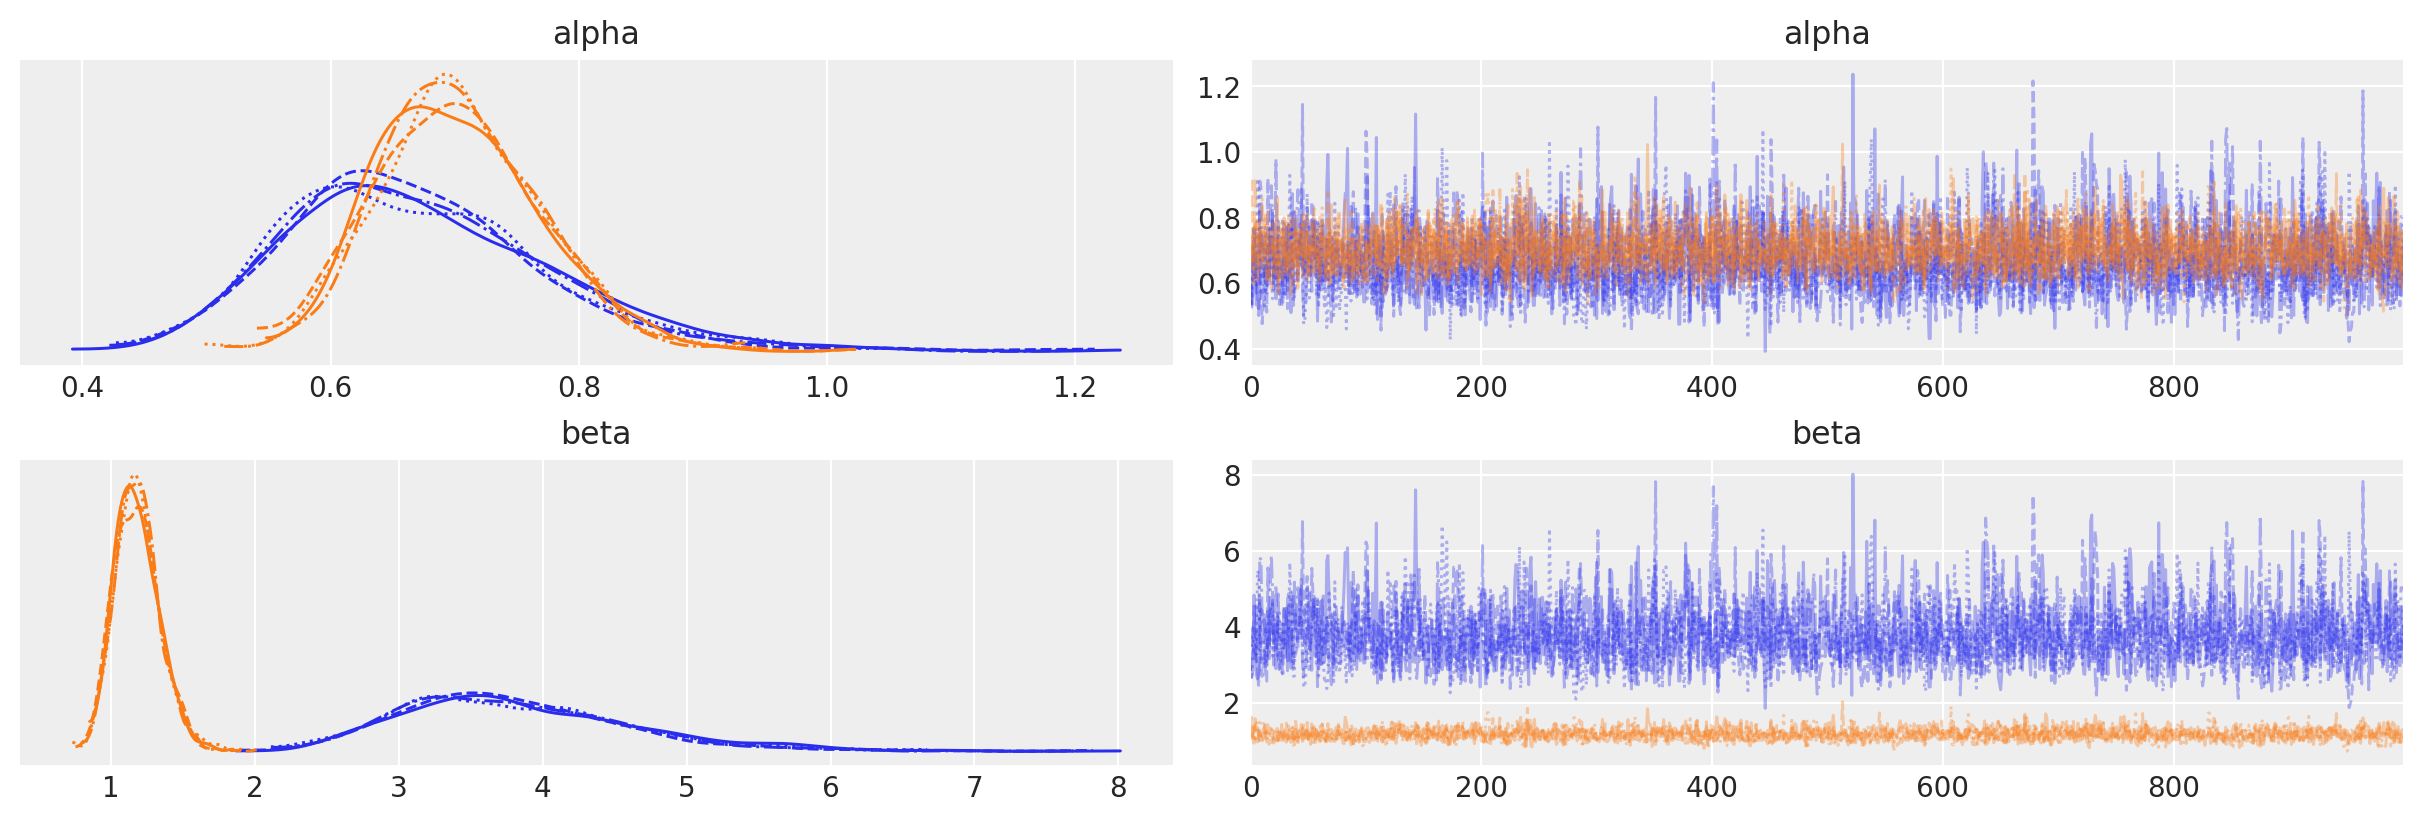

In [13]:
az.plot_trace(sbg_mcmc.idata,var_names=["alpha","beta"])

Fit summaries and trace plots look good. Let's compare the fitted posterior distributions to the scalar parameter estimates from the research:

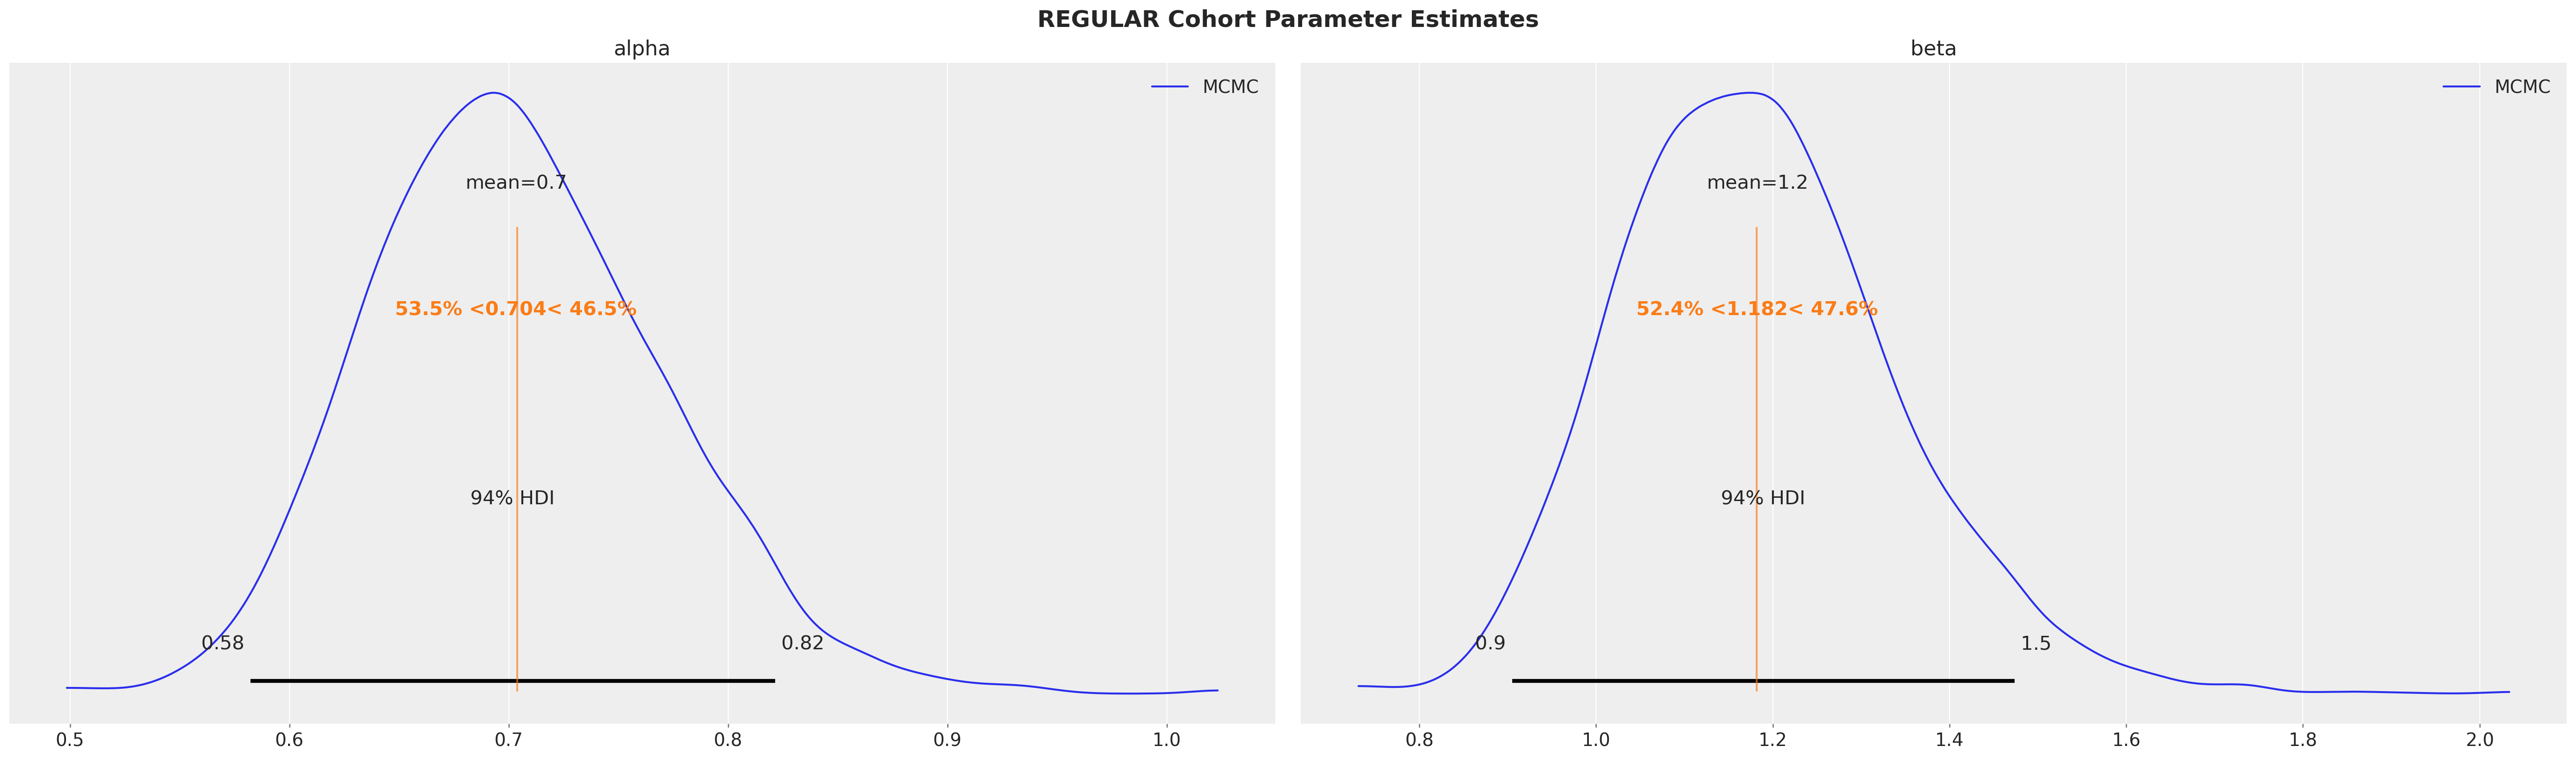

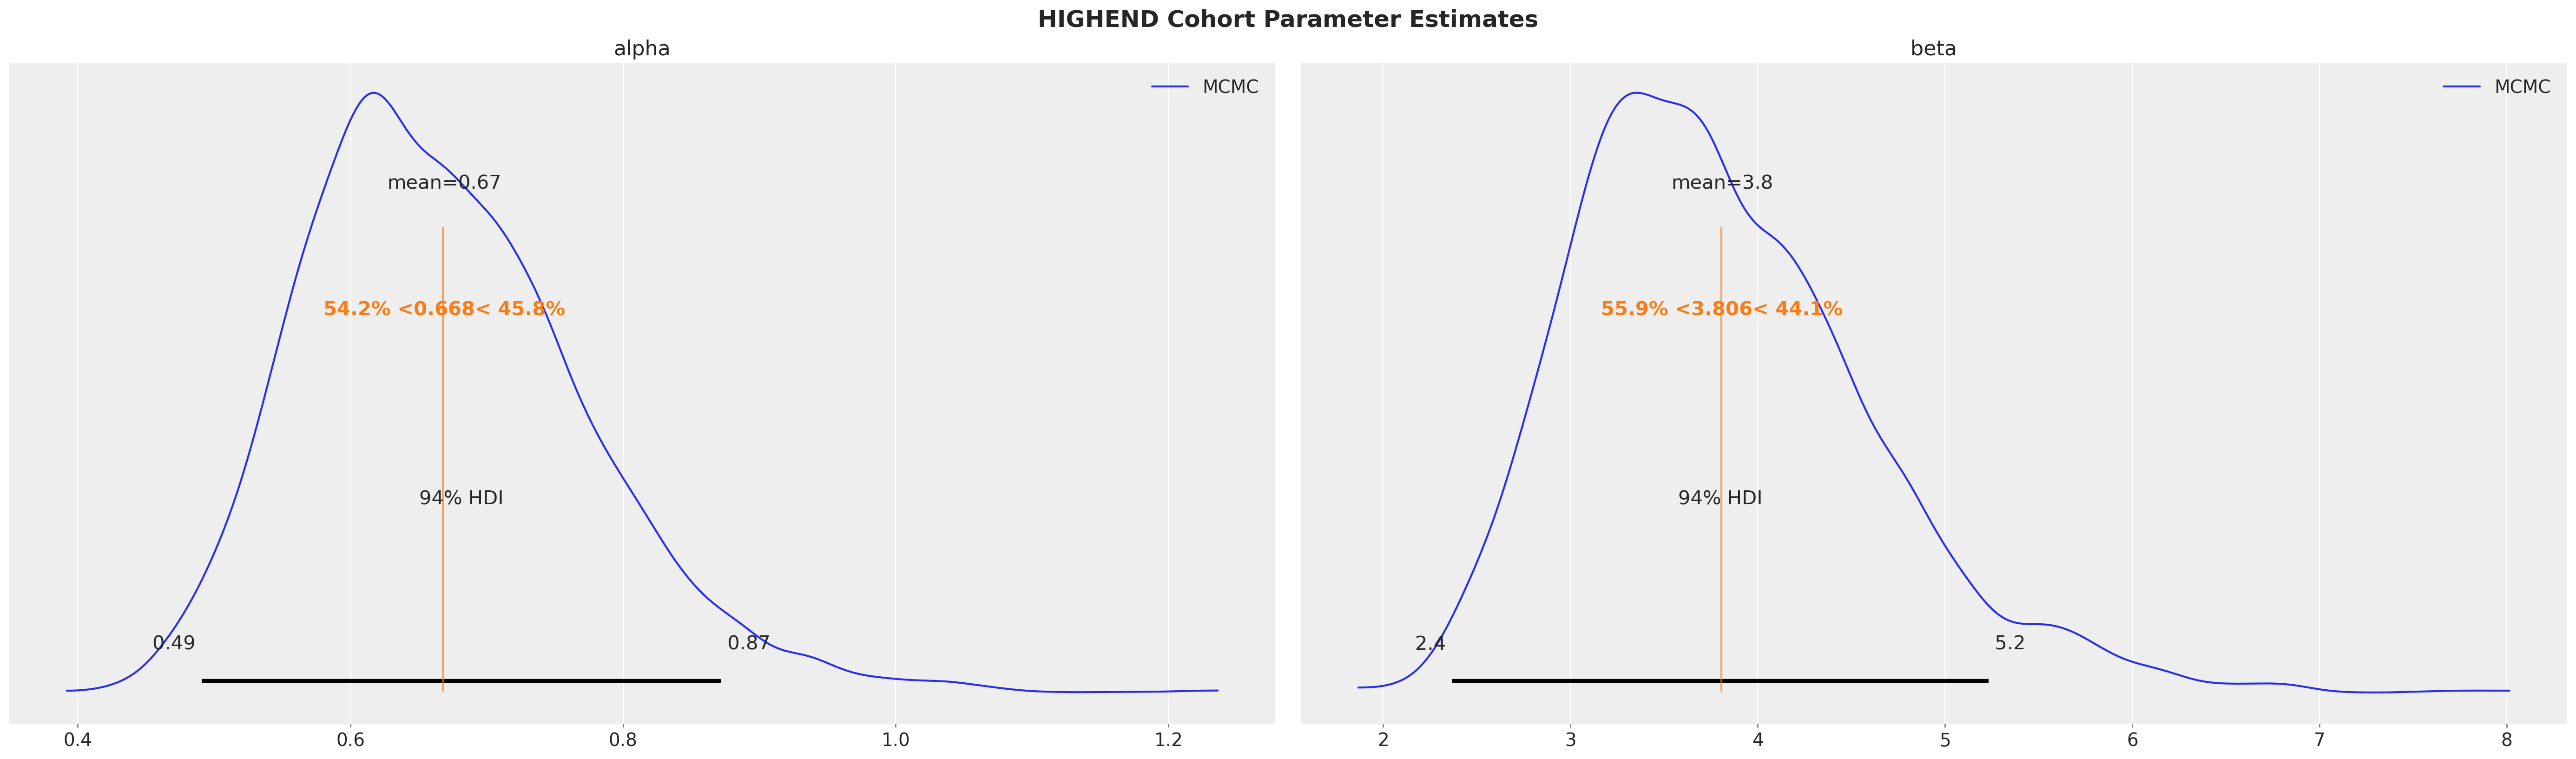

In [60]:
for i, var_name in enumerate(mle_research_parameters.keys()):
    az.plot_posterior(
        sbg_mcmc.idata.sel(cohort=var_name),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[var_name],
        label = "MCMC",
    )
    plt.gcf().suptitle(f"{var_name.upper()} Cohort Parameter Estimates", fontsize=18, fontweight="bold");

The fitted posterior mean values align with the MLE values described in the research paper! MCMC sampling also gives us useful information about the uncertainty of the fits. Note how the mean values are within the 94% HDI intervals but not perfectly centered, indicating the posteriors are assymetrical.

### Model Evaluation with Cohorts

Recall how the model was fit to the first $8$ time periods and the remaining $5$ were withheld for testing. The `survival_rate_aggregation()` function from earlier can be used to summarize the full dataset in a format equivalent to that of `research_data` to evaluate predictive performance. The aggregated survival data can then be used to create an array of $T$ values for testing:

In [256]:
# This would normally be ran on the full dataset of train/test data, which is already aggregated in this case.
# Here we are aggregating the model fit data to get the training period endpoint:
df_fit_eval = survival_rate_aggregation(cohort_df)

# get T values of test and training data
test_T = len(research_data)
train_T = len(df_fit_eval)


T_eval_range = np.arange(train_T * -1, test_T - train_T, 1)
T_eval_range

array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

Normally only the range of `train_T : test_T` values would be required, but for illustrative purposes we will also run predictions on past (i.e., negative) time periods.

The sBG [*survival function*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive) is the probability customers within a given cohort are still active after a specified time period, and is called by `model.expected_probability_alive()`:

In [19]:
expected_survival_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_probability_alive(
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

Let's plot the predictive credibility intervals over time against the observed data:

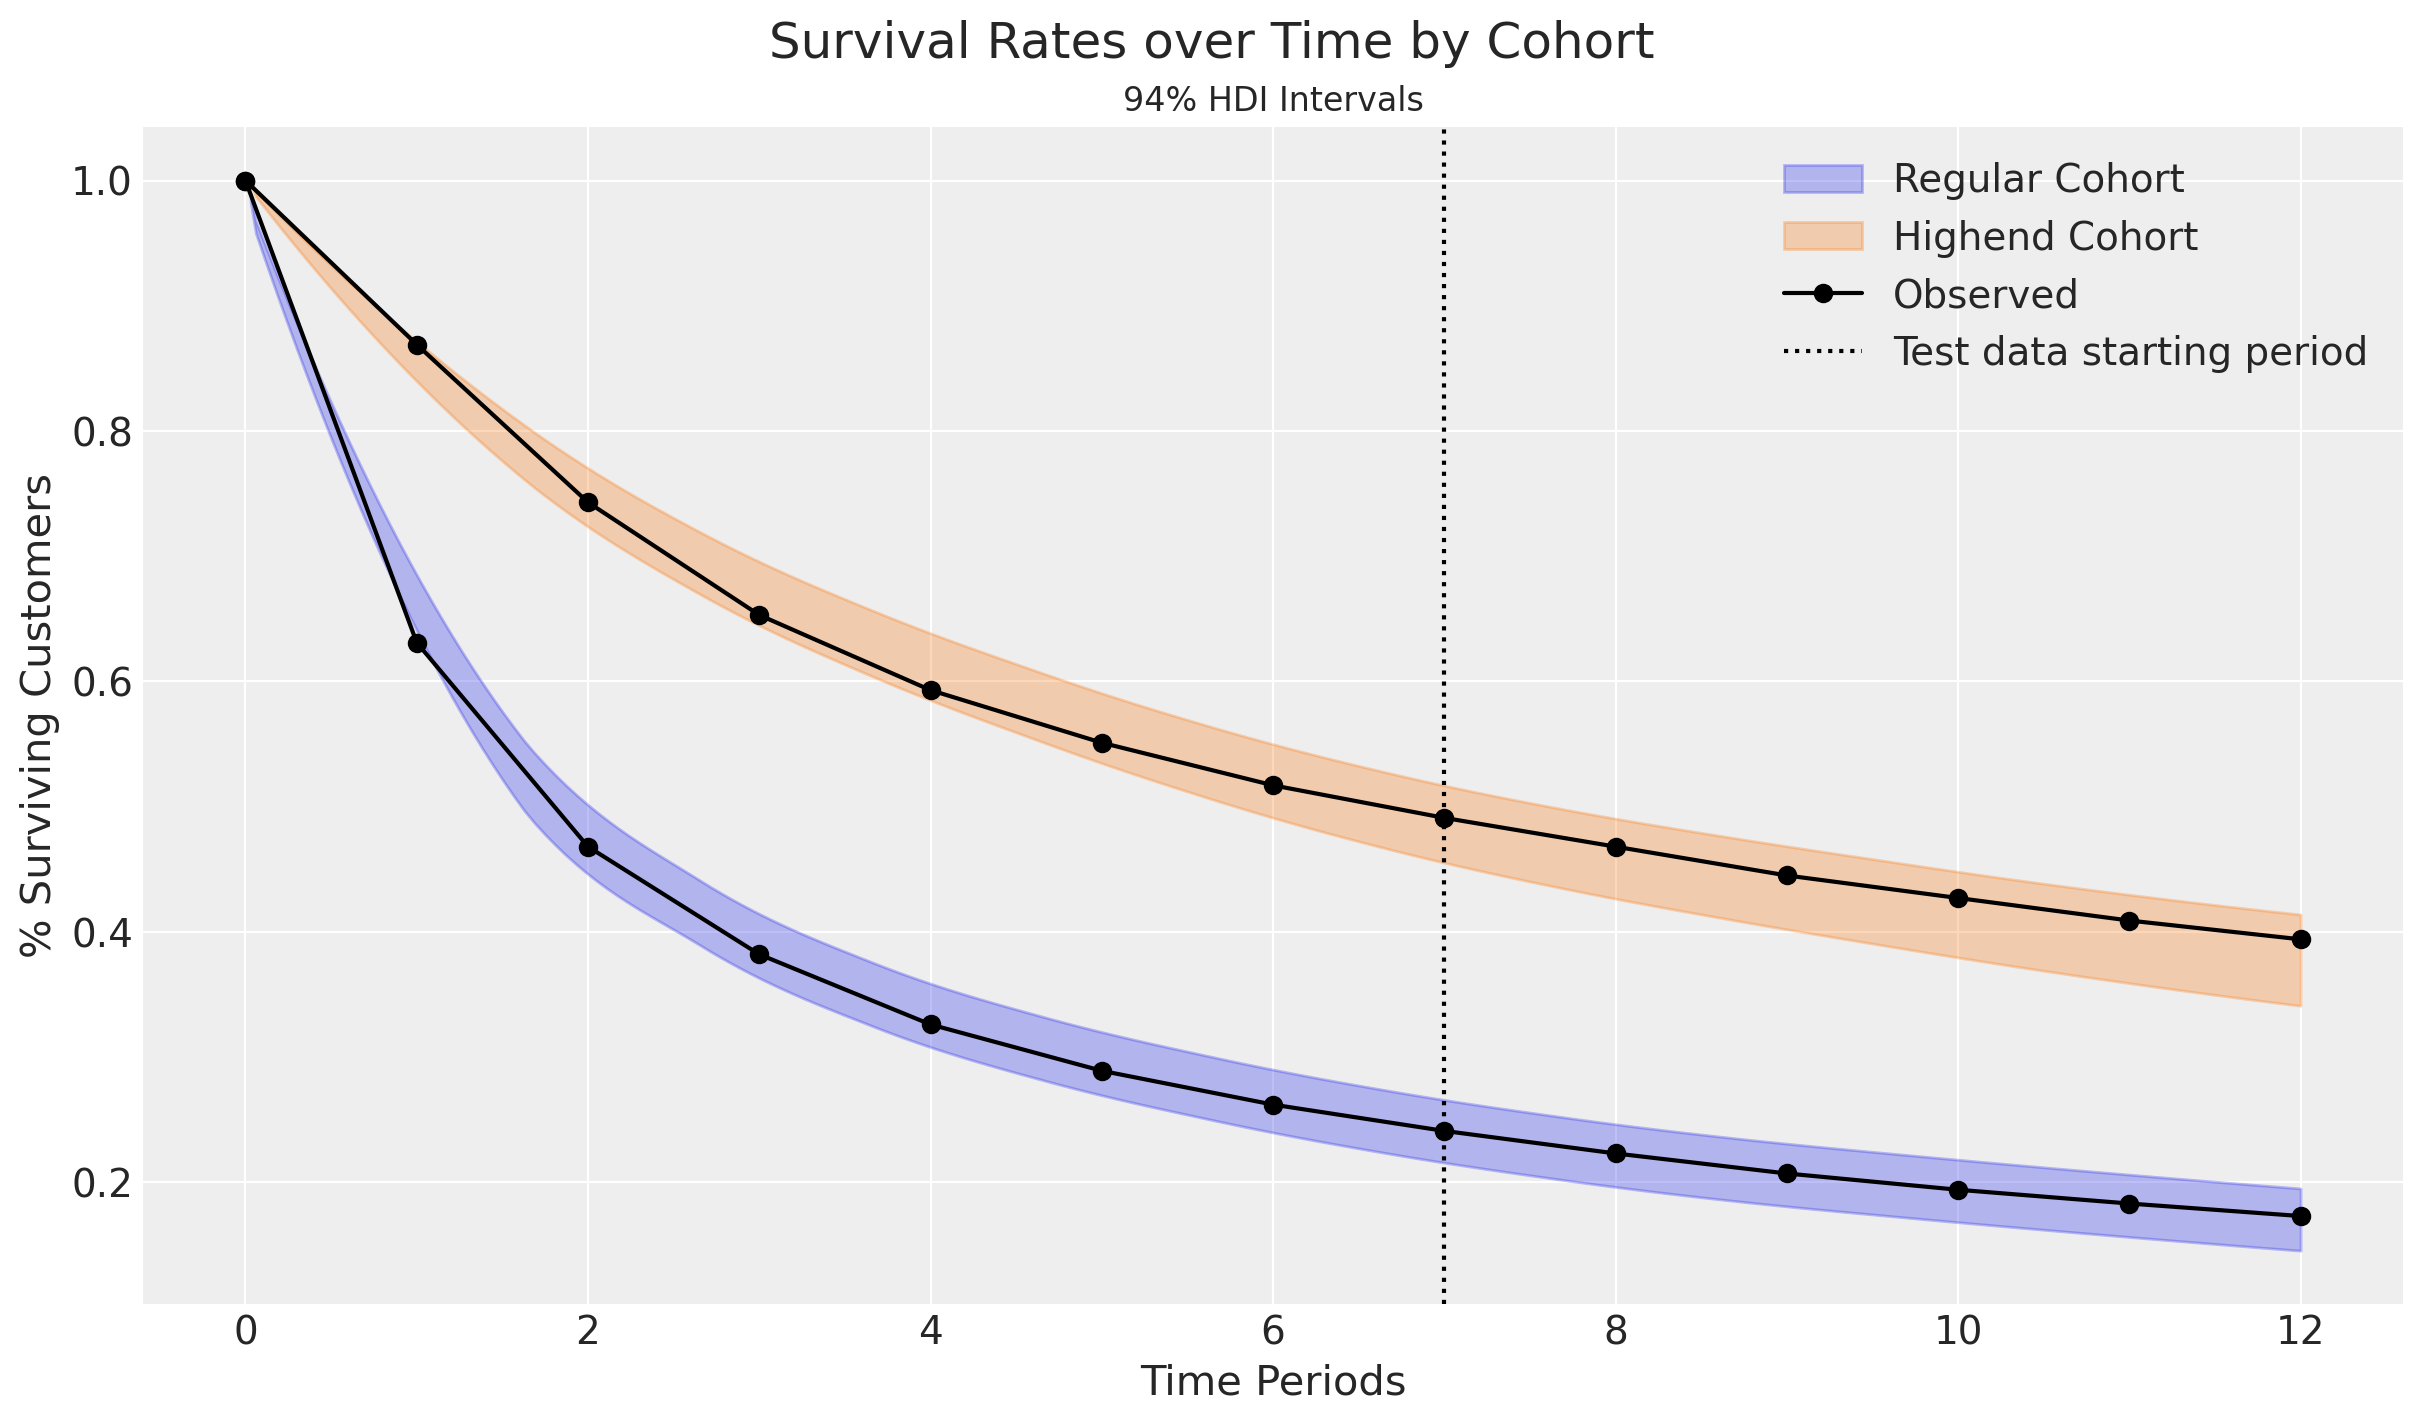

In [114]:
az.plot_hdi(
        range(test_T),
        expected_survival_rates.sel(cohort="regular").mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "Regular Cohort"},
    )
az.plot_hdi(
        range(test_T),
        expected_survival_rates.sel(cohort="highend").mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "Highend Cohort"},
    )
plt.plot(range(test_T), research_data["highend"]/100, marker='o', color="k", label="Observed")
plt.plot(range(test_T), research_data["regular"]/100, marker='o', color="k")
plt.ylabel("% Surviving Customers")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Survival Rates over Time by Cohort",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

Observed survival rates fall well within the 94% credibility intervals!

We can also predict the [*retention rate*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate) by cohort, which is defined as the proportion of customers active in period $T-1$ who are still active in period $T$:

In [22]:
expected_retention_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_retention_rate(
            future_t=T,
        )
        for T in T_eval_range[1:] # omit starting time period (see below)
    ],
    dim="T",
).transpose(..., "T")

# Calculate observed retention rates by cohort.
# Initial start period does not have a retention rate, so retention array is 1 time period shorter than observed.
retention_rate_highend_obs = research_data["highend"][1:].values / research_data["highend"][:-1].values
retention_rate_regular_obs = research_data["regular"][1:].values / research_data["regular"][:-1].values

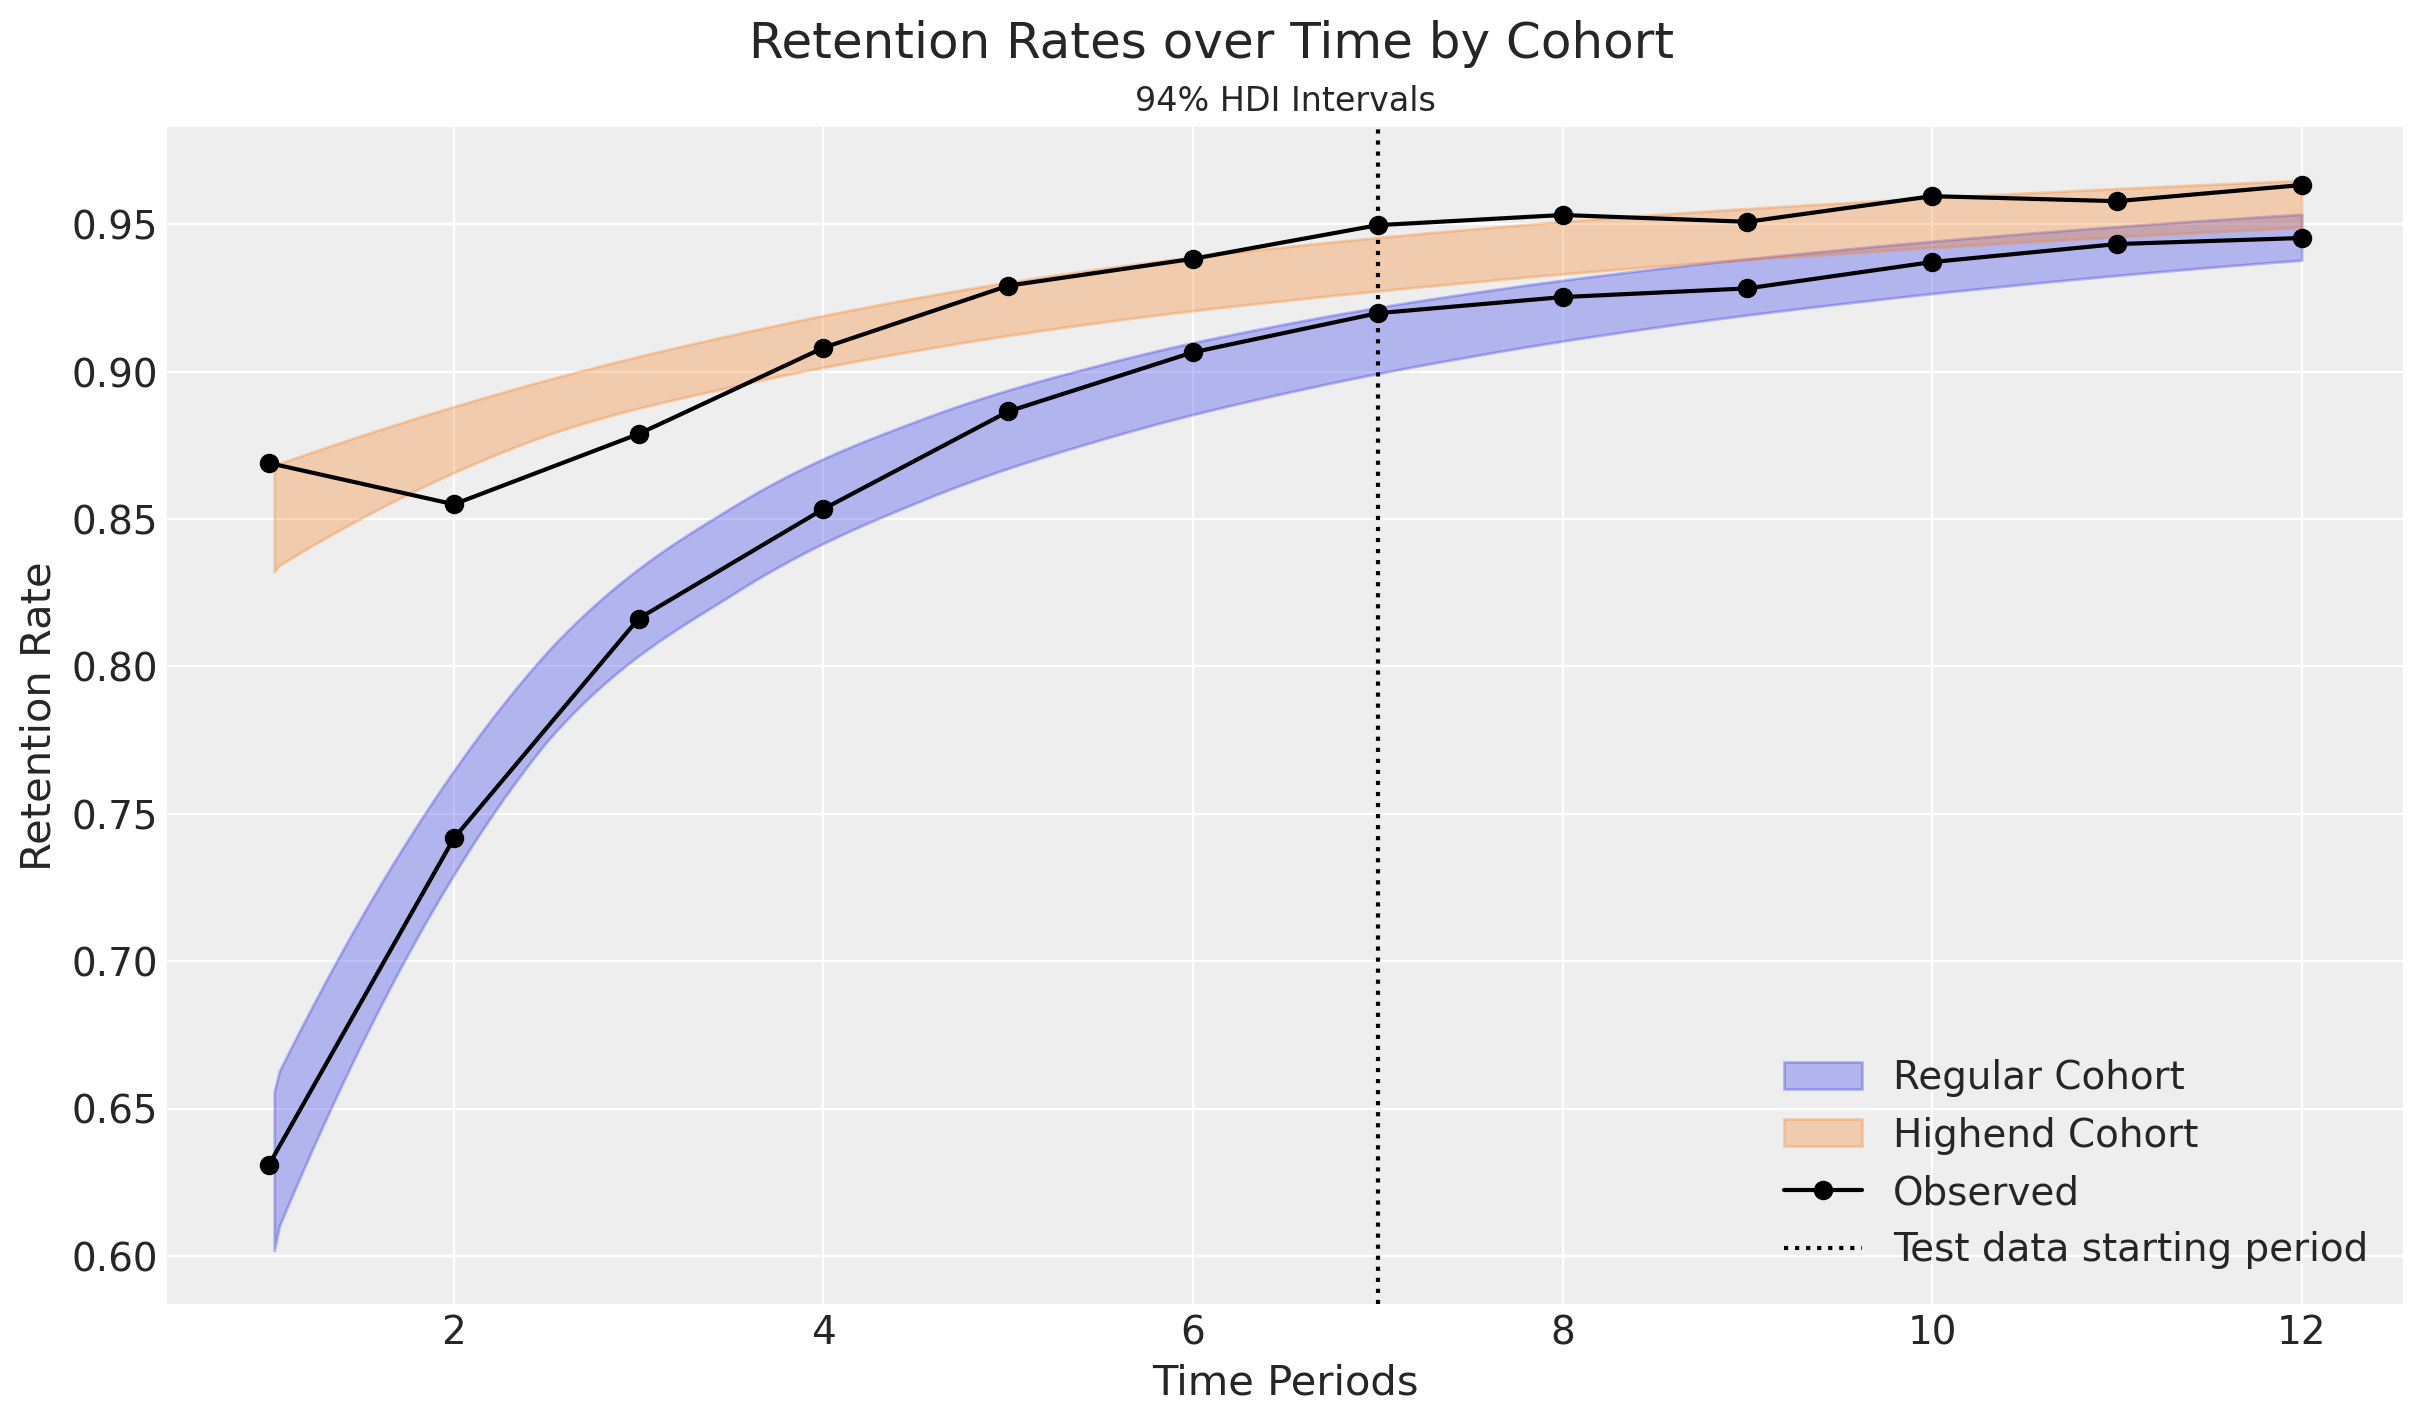

In [113]:
az.plot_hdi(
        range(1, test_T),
        expected_retention_rates.sel(cohort="regular").mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "Regular Cohort"},
    )
az.plot_hdi(
        range(1, test_T),
        expected_retention_rates.sel(cohort="highend").mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "Highend Cohort"},
    )
plt.plot(range(1, test_T), retention_rate_highend_obs, marker='o',color="k", label="Observed")
plt.plot(range(1, test_T), retention_rate_regular_obs, marker='o', color="k")
plt.ylabel("Retention Rate")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Retention Rates over Time by Cohort",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

Retention rate predictions fall within the 94% credibility intervals for the Regular Cohort. The Highend cohort is more erratic but improves over time.

The plots also highlight an interesting implication from the model: Retention rates are expected to increase over time as higher-risk customers drop out. This is a direct outcome of customer heterogeneity. Heterogeneity within cohorts can modeled further with the addition of covariates.

## Reproduce Research Results with Covariates

For this particular dataset, both cohorts can be indicated with a simple binary covariate since they start in the same time period. Let's modify the fit data to do so:

In [24]:
# Create a covariate column to identify highend customers
cohort_df["highend_customer"] = np.where(cohort_df["cohort"] == "highend", 1, 0)
# Update cohort column to a single "population" cohort
covariate_df = cohort_df.assign(cohort="population")
covariate_df

customer_id  recency  T      cohort  highend_customer
0               1        1  8  population                 1
1               2        1  8  population                 1
2               3        1  8  population                 1
3               4        1  8  population                 1
4               5        1  8  population                 1
...           ...      ... ..         ...               ...
1995         1996        8  8  population                 0
1996         1997        8  8  population                 0
1997         1998        8  8  population                 0
1998         1999        8  8  population                 0
1999         2000        8  8  population                 0

[2000 rows x 5 columns]

Recall $\alpha$ and $\beta$ represent the shape parameters for the Beta dropout distribution. To include time-invariant covariates in our model, we simply modify these parameters as follows:

$$\alpha = \alpha_0e^{-\gamma_1'z_1}$$
$$\beta = \beta_0e^{-\gamma_2'z_2}$$

Where $\gamma_1$ and $\gamma_2$ are coefficients capturing the impact of the covariates, and $z_1$ and $z_2$ the covariate arrays for each customer.

These additional parameters are automatically created when covariate column names are specified in the `model_config`:

In [25]:
sbg_covar = clv.ShiftedBetaGeoModel(
    data=covariate_df,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg_covar.build_model()
sbg_covar

Shifted Beta-Geometric
                      phi ~ Uniform(0, 1)
                    kappa ~ Pareto(1, 1)
dropout_coefficient_alpha ~ Normal(0, 1)
 dropout_coefficient_beta ~ Normal(0, 1)
              alpha_scale ~ Deterministic(f(kappa, phi))
               beta_scale ~ Deterministic(f(kappa, phi))
                    alpha ~ Deterministic(f(dropout_coefficient_alpha, kappa, phi))
                     beta ~ Deterministic(f(dropout_coefficient_beta, kappa, phi))
                  dropout ~ Censored(ShiftedBetaGeometric(alpha, beta), -inf, <constant>)

### Model Fitting with Adaptive Differential Evolution Metropolis

MCMC model fits require more time with covariates compared to cohorts. A gradient-free sampler like [`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html) will converge in far less time, but requires more samples.

In [53]:
sbg_covar.fit(fit_method='demz', tune=2000, draws=4000) # 'demz' requires more tune/draws for convergence

# After fitting, remove redundant samples to reduce model size and increase predictive method processing speed
sbg_covar = sbg_covar.thin_fit_result(keep_every=4)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa, dropout_coefficient_alpha, dropout_coefficient_beta]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 4 seconds.


In [55]:
sbg_covar.fit_summary(var_names=["alpha","beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[1]    0.667  0.104   0.490    0.851      0.003    0.004    1052.0   
alpha[2]    0.667  0.104   0.490    0.851      0.003    0.004    1052.0   
alpha[3]    0.667  0.104   0.490    0.851      0.003    0.004    1052.0   
alpha[4]    0.667  0.104   0.490    0.851      0.003    0.004    1052.0   
alpha[5]    0.667  0.104   0.490    0.851      0.003    0.004    1052.0   
...           ...    ...     ...      ...        ...      ...       ...   
beta[1996]  1.204  0.154   0.928    1.495      0.005    0.003    1048.0   
beta[1997]  1.204  0.154   0.928    1.495      0.005    0.003    1048.0   
beta[1998]  1.204  0.154   0.928    1.495      0.005    0.003    1048.0   
beta[1999]  1.204  0.154   0.928    1.495      0.005    0.003    1048.0   
beta[2000]  1.204  0.154   0.928    1.495      0.005    0.003    1048.0   

            ess_tail  r_hat  
alpha[1]      1143.0   1.00  
alpha[2]      1143.0   1.00  
alpha[3]      1143.0   1.00  
alpha[4]      1143.0   1.00  
alpha[5]      1143.0   1.00  
...              ...    ...  
beta[1996]    1346.0   1.01  
beta[1997]    1346.0   1.01  
beta[1998]    1346.0   1.01  
beta[1999]    1346.0   1.01  
beta[2000]    1346.0   1.01  

[4000 rows x 9 columns]

Since we are now using covariates to control for heterogeniety between customers, `alpha` and `beta` parameter pairs are calculated for every `customer_id`.

array([[<Axes: title={'center': 'alpha_scale'}>,
        <Axes: title={'center': 'alpha_scale'}>],
       [<Axes: title={'center': 'beta_scale'}>,
        <Axes: title={'center': 'beta_scale'}>],
       [<Axes: title={'center': 'dropout_coefficient_alpha'}>,
        <Axes: title={'center': 'dropout_coefficient_alpha'}>],
       [<Axes: title={'center': 'dropout_coefficient_beta'}>,
        <Axes: title={'center': 'dropout_coefficient_beta'}>]],
      dtype=object)

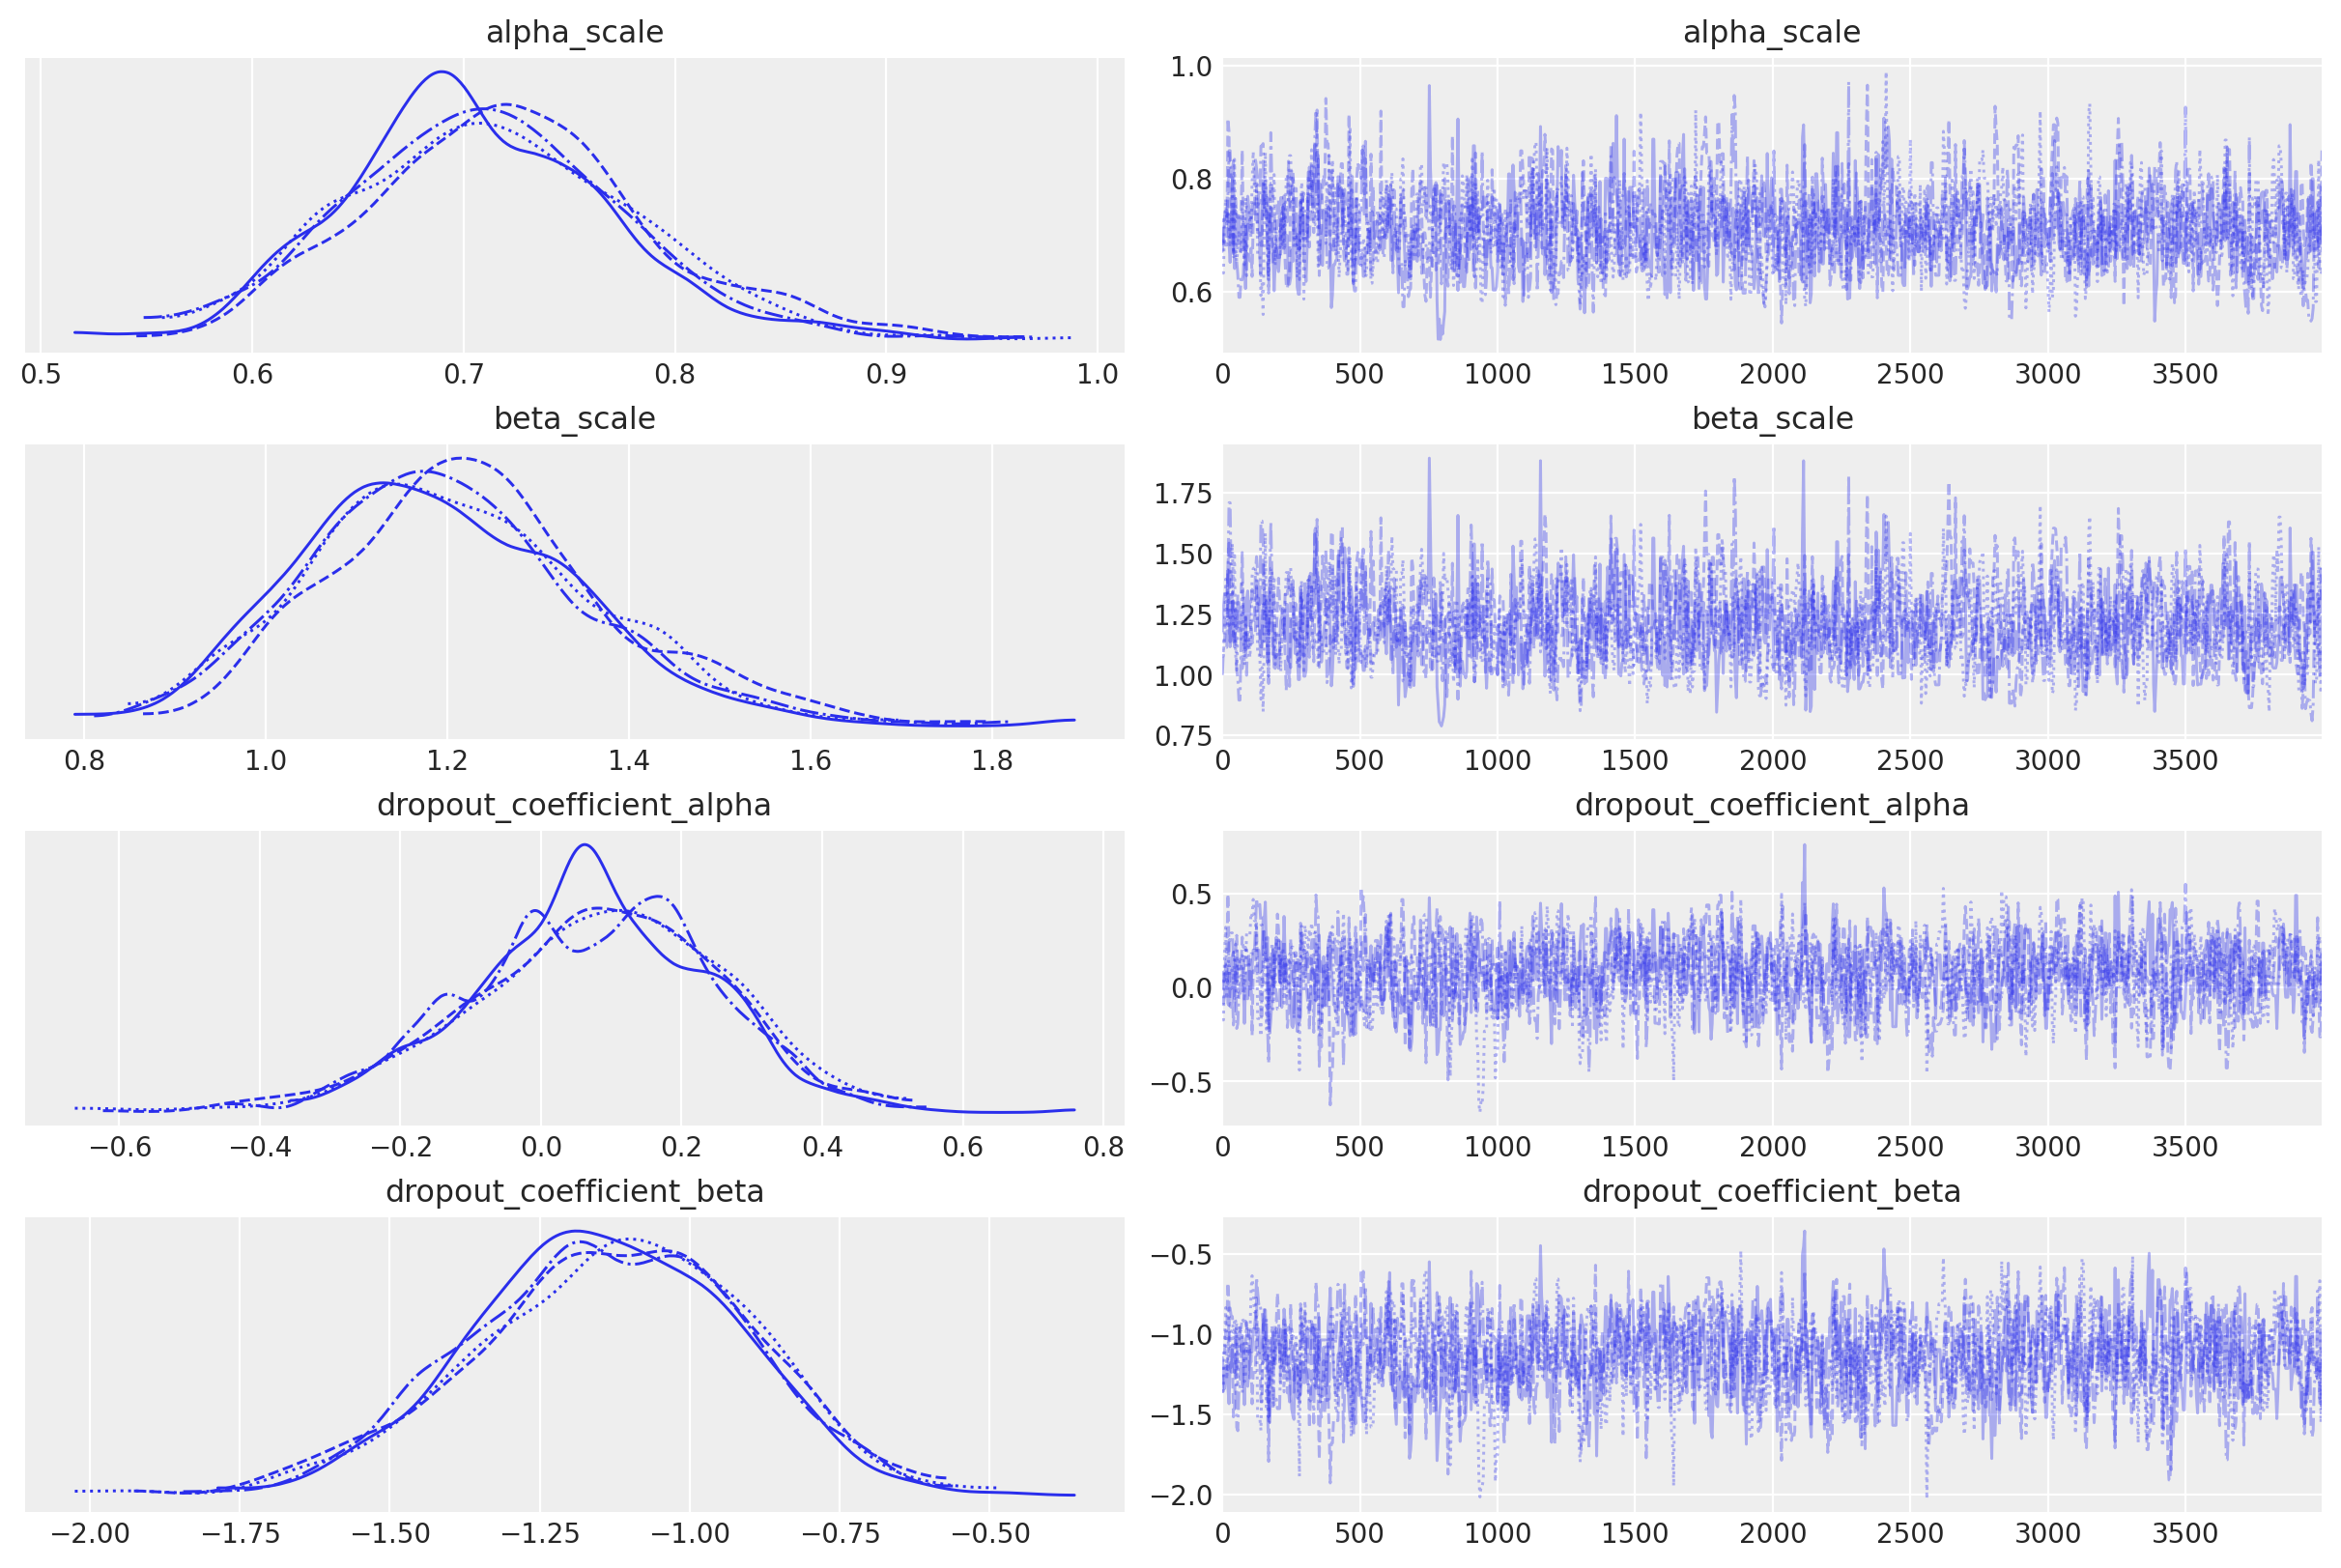

In [56]:
az.plot_trace(sbg_covar.idata,var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

`alpha_scale` and `beta_scale` parameters represent the baseline for each cohort, and `dropout_coefficient` posteriors indicate covariate effects for the customer population. Customer-level `alpha` and `beta` values are calculated as follows: 

```python
customer_param = cohort_param * exp(-covar_coeff * customer_covar)
```

In this simple example with a single cohort ("population") and binary covariate variable ("highend customer"), we can see the mean impact of this covariate on `alpha` is near-zero, but the impact on `beta` is significantly higher.

Recall the mean of the Beta distribution:

$$E(\theta) = \frac{\alpha}{\alpha + \beta}$$

The negatively-valued posterior indicates `beta` will *increase* for each highend customer, and reduce the dropout expectation.

### Model Evaluation with Covariates
To compare covariate `alpha` and `beta` estimates to the original research, we can use the `customer_id` to extract parameters for known highend and regular customers:

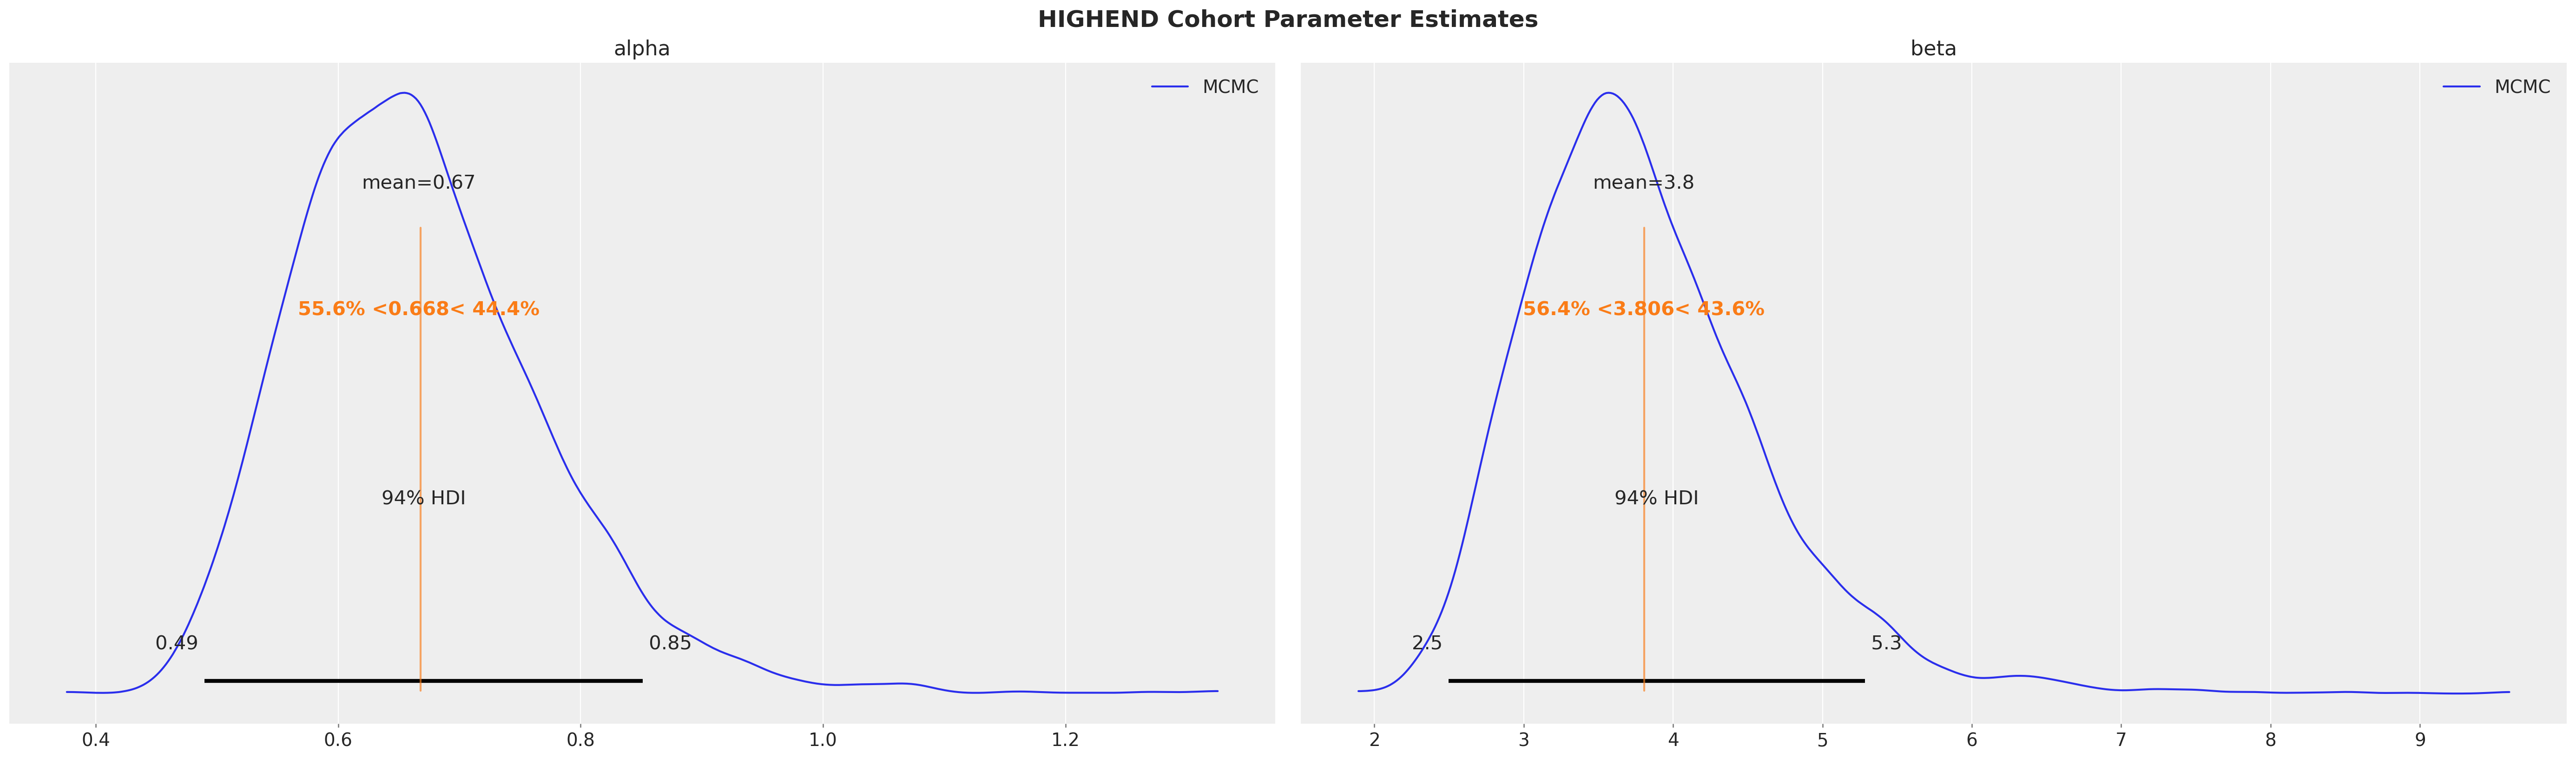

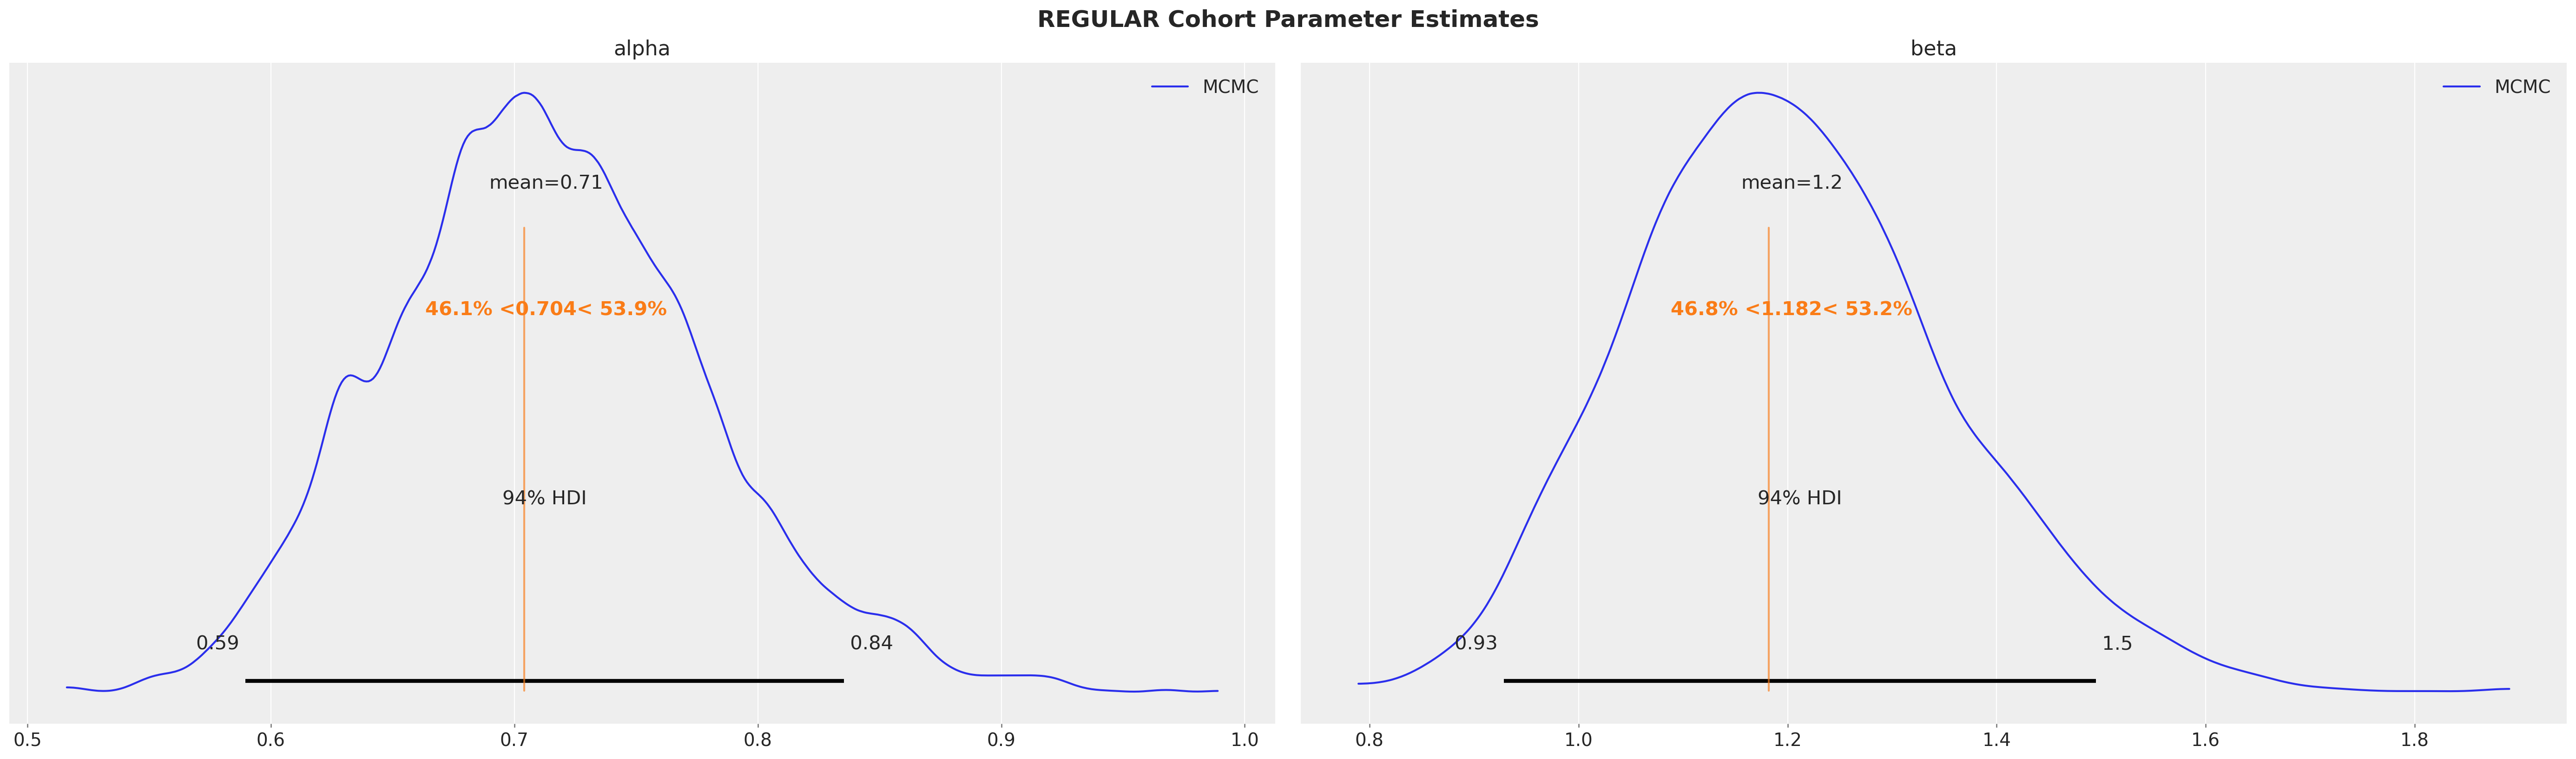

In [76]:
covariate_customer_ids = {
    "highend": 1,
    "regular": 2000,
}

for cohort, customer_id in covariate_customer_ids.items():
    az.plot_posterior(
        sbg_covar.idata.sel(customer_id=customer_id),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[cohort],
        label = "MCMC",
    )
    plt.gcf().suptitle(f"{cohort.upper()} Customer Parameter Estimates", fontsize=18, fontweight="bold");

Parameter estimates are identical regardless of the customer being identified by cohort or covariate! Survival predictions are identical as well:

In [77]:
# if running predictions on out-of-sample data, or a subset of the fit data,
# be sure to exclude inactive customers:
active_covariate_customers = covariate_df.query("recency==T").copy()

highend_active = active_covariate_customers.query("highend_customer==1").copy()
regular_active = active_covariate_customers.query("highend_customer==0").copy()

# run survival predictions seperately for regular and highend customers
expected_survival_rates_hi = xr.concat(
    objs=[
        sbg_covar.expected_probability_alive(
            data=highend_active,
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

expected_survival_rates_reg = xr.concat(
    objs=[
        sbg_covar.expected_probability_alive(
            data=regular_active,
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

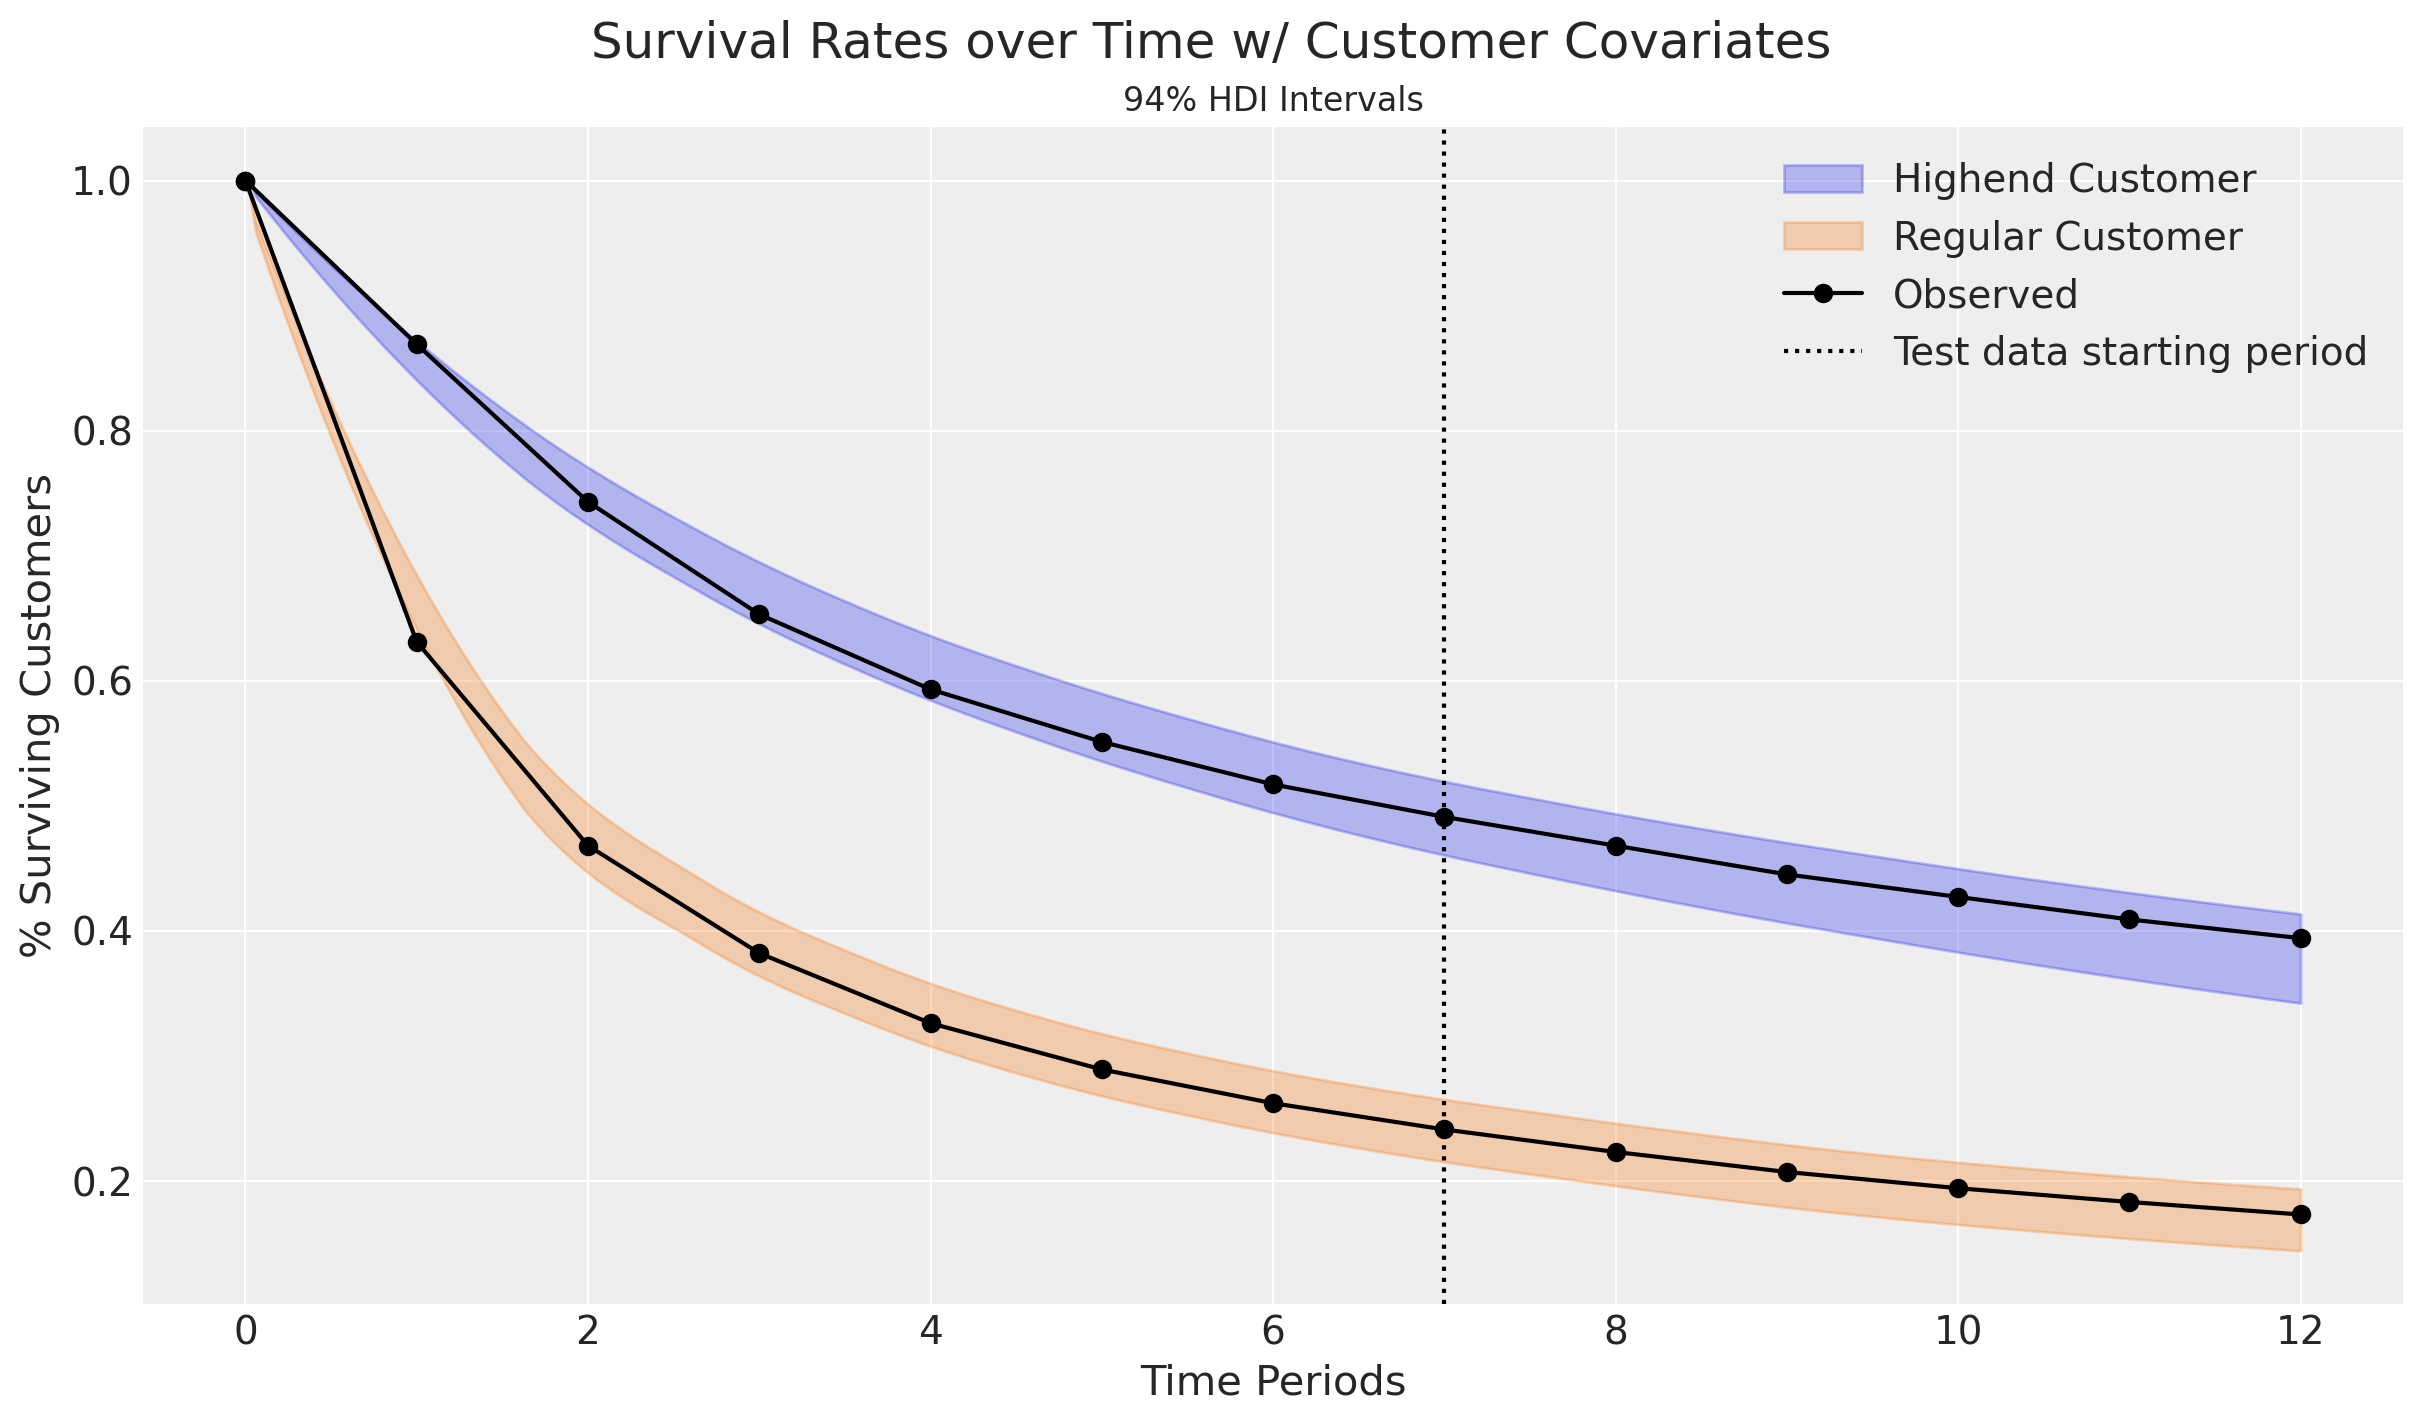

In [121]:
az.plot_hdi(
        range(test_T),
        expected_survival_rates_hi.mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "Highend Customer"},
    )
az.plot_hdi(
        range(test_T),
        expected_survival_rates_reg.mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "Regular Customer"},
    )

plt.plot(range(test_T), research_data["highend"]/100, marker='o', color="k", label="Observed")
plt.plot(range(test_T), research_data["regular"]/100, marker='o', color="k")
plt.ylabel("% Surviving Customers")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Survival Rates over Time w/ Customer Covariates",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

# End-to-End Example with Cohorts and Covariates
##### Tutorial Notebook Outstanding Tasks
- [ ] Add latent dropout distribution for research results
- [ ] additional predictive methods, and dropout distribution plotting

Now let's use the previous data to create a more realistic example with both cohorts and covariates.

and `demz` can sometimes get stuck with complex posterior geometry.

In [171]:
# Generate 7 monthly cohorts with shifted observation periods
cohort_dfs = []

for month in range(1, 8):
    # Calculate observation period: January (month 1) has 8 periods, July (month 7) has 2 periods
    observation_periods = 9 - month  # 8 for month 1, 7 for month 2, ..., 2 for month 7
    month_cohort_name = f"2025-{month:02d}"
    
    # Copy the covariate data
    monthly_cohort_df = covariate_df.copy()
    
    # Truncate recency to the observation period
    # If a customer churned after the observation period, they appear alive at T
    monthly_cohort_df["recency"] = monthly_cohort_df["recency"].clip(upper=observation_periods)
    
    # Update T to the correct observation period for this cohort
    monthly_cohort_df["T"] = observation_periods
    
    # Add the time-based cohort (month they joined)
    monthly_cohort_df["cohort"] = month_cohort_name
    
    cohort_dfs.append(monthly_cohort_df)

# Combine all monthly cohorts
monthly_cohort_dataset = pd.concat(cohort_dfs, ignore_index=True)

# Recreate customer_id to be unique across all cohorts
monthly_cohort_dataset["customer_id"] = monthly_cohort_dataset.index + 1

# Reorder columns for clarity
monthly_cohort_dataset = monthly_cohort_dataset[[
    'customer_id', 'recency', 'T', 'cohort', 'highend_customer', 
]]

# Display summary
print(f"Total customers: {len(monthly_cohort_dataset):,}")
print(f"\nMonthly cohorts: {sorted(monthly_cohort_dataset['cohort'].unique())}")

# Verify T values by cohort
print("\nObservation periods (T) by cohort:")
print(monthly_cohort_dataset.groupby('cohort')['T'].agg(['first', 'min', 'max']))

# Verify that recency <= T for all customers
print(f"\nAll recency <= T: {(monthly_cohort_dataset['recency'] <= monthly_cohort_dataset['T']).all()}")

Total customers: 14,000

Monthly cohorts: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07']

Observation periods (T) by cohort:
         first  min  max
cohort                  
2025-01      8    8    8
2025-02      7    7    7
2025-03      6    6    6
2025-04      5    5    5
2025-05      4    4    4
2025-06      3    3    3
2025-07      2    2    2

All recency <= T: True


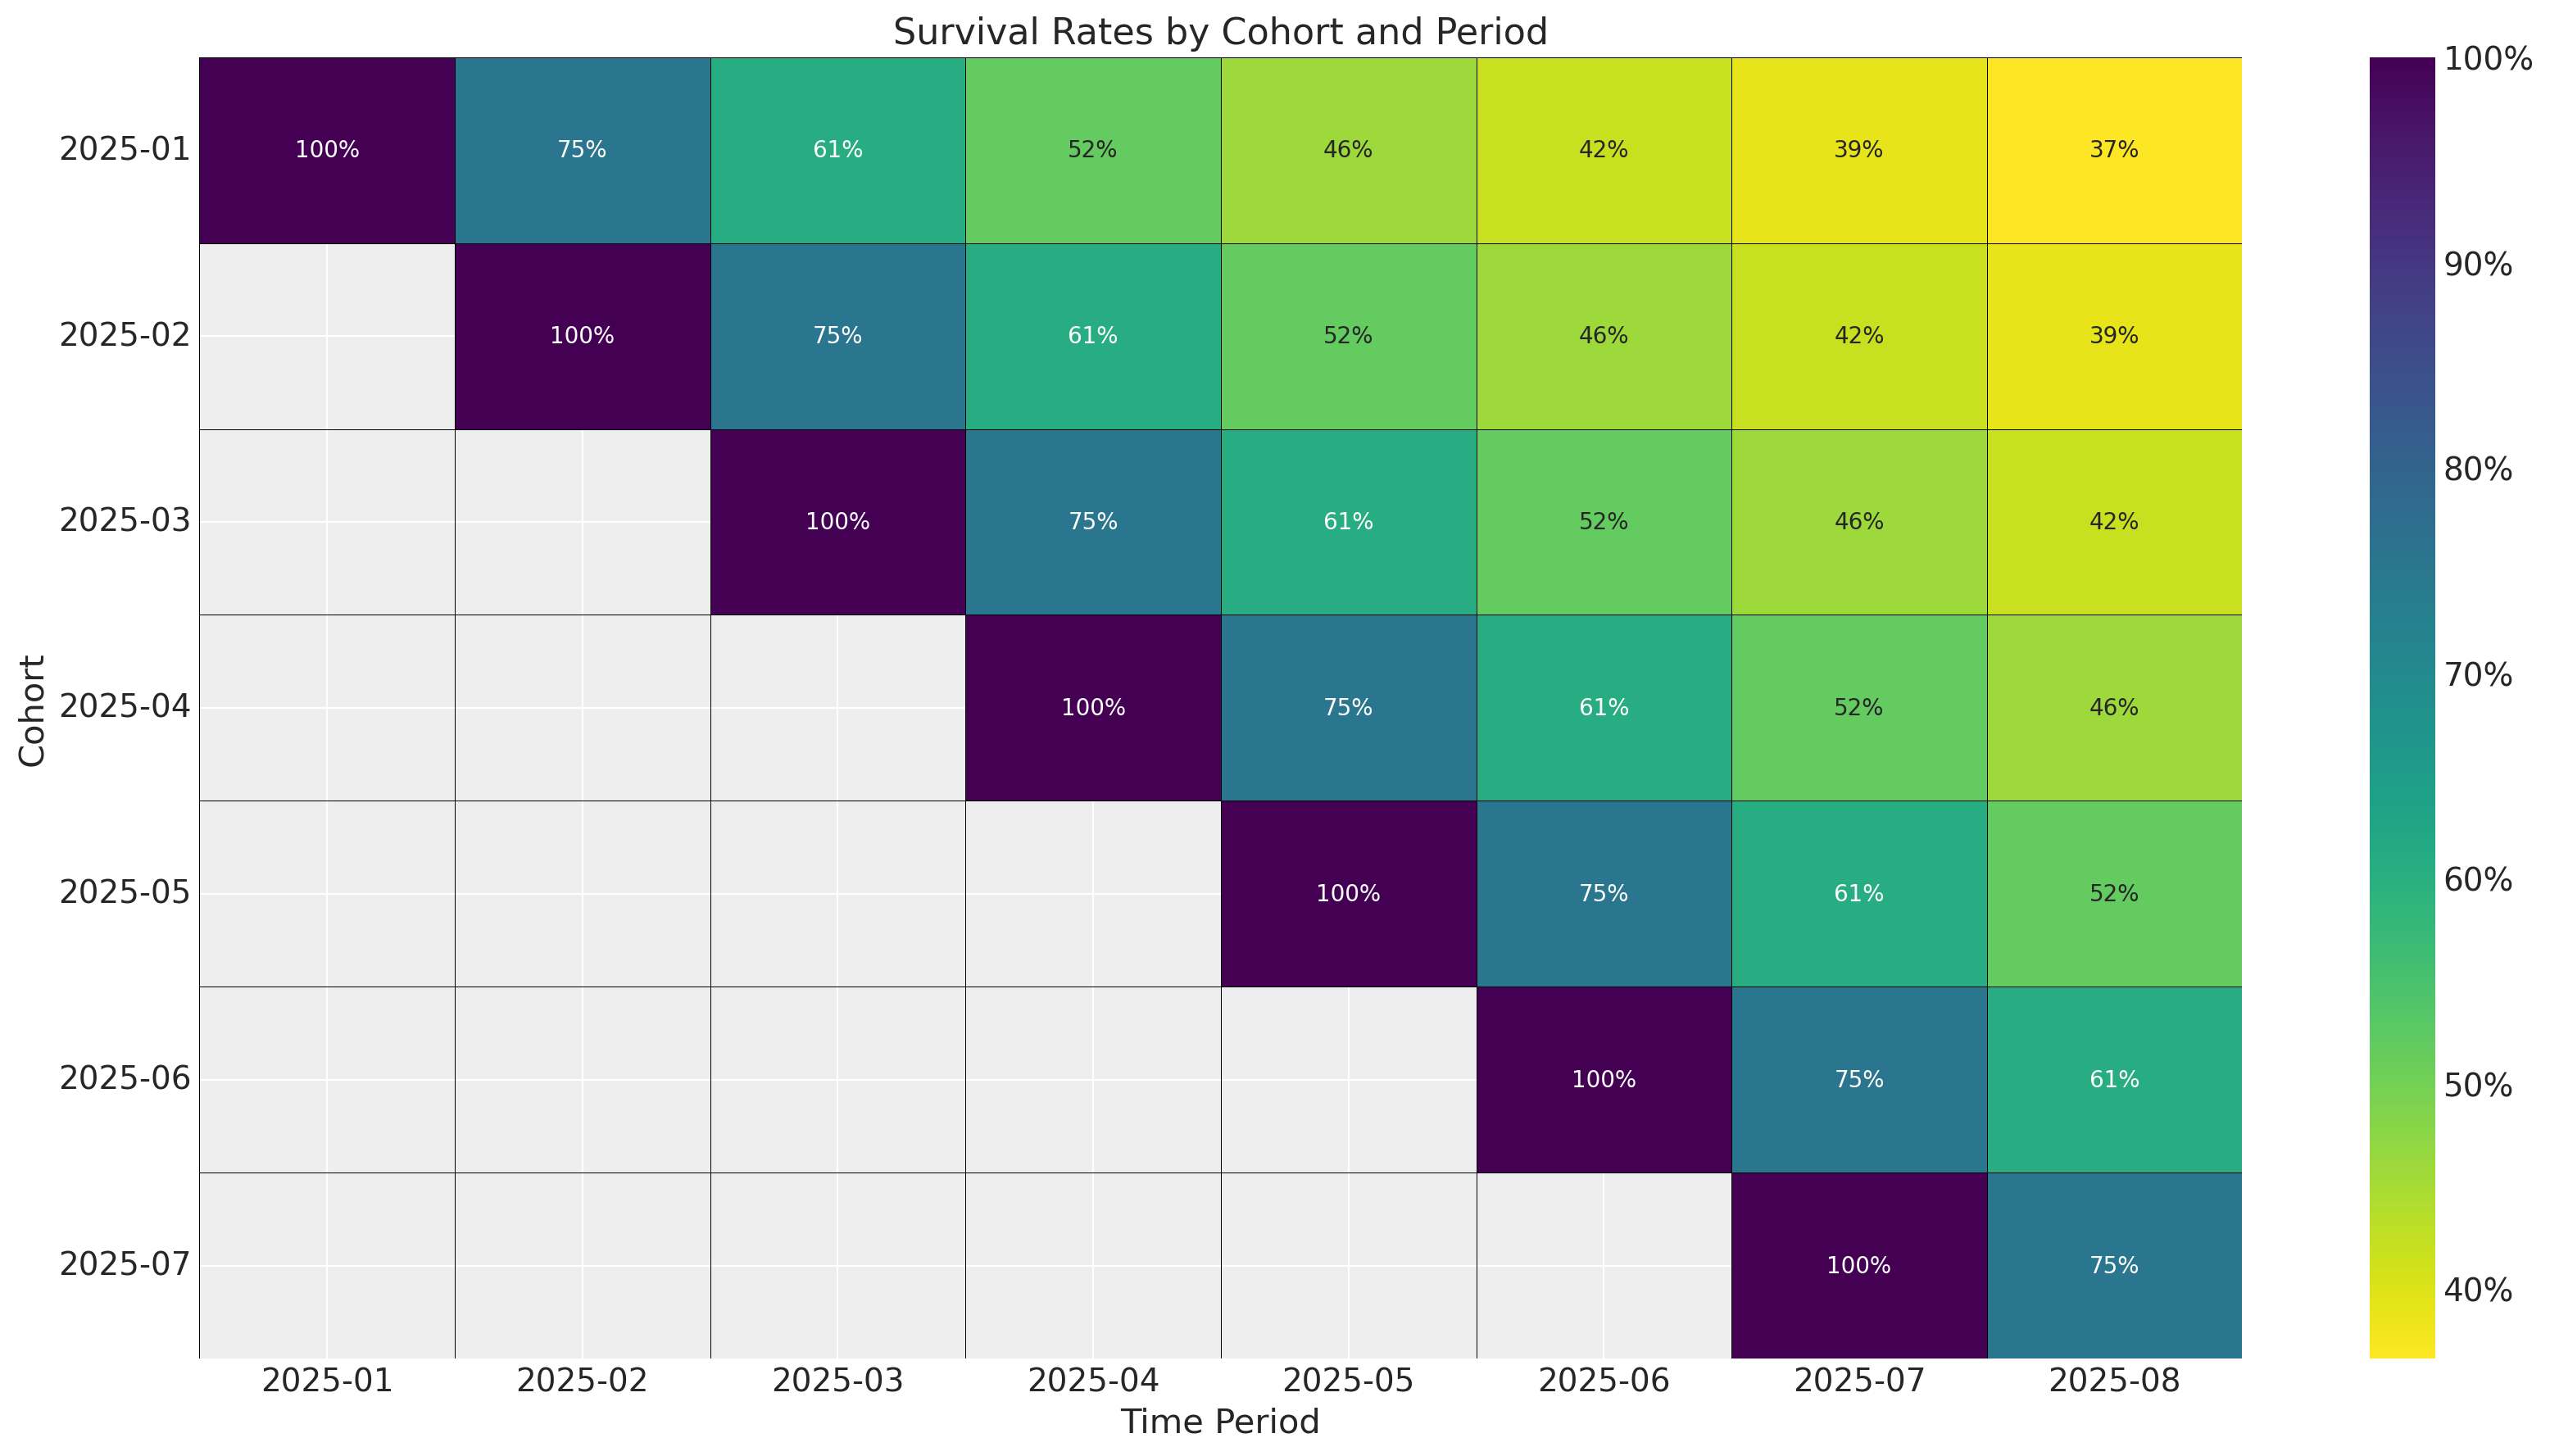


Pivoted DataFrame structure:
period   2025-01  2025-02  2025-03  2025-04  2025-05  2025-06  2025-07  \
cohort                                                                   
2025-01      1.0     0.75   0.6055   0.5175   0.4595   0.4200   0.3895   
2025-02      NaN     1.00   0.7500   0.6055   0.5175   0.4595   0.4200   
2025-03      NaN      NaN   1.0000   0.7500   0.6055   0.5175   0.4595   
2025-04      NaN      NaN      NaN   1.0000   0.7500   0.6055   0.5175   
2025-05      NaN      NaN      NaN      NaN   1.0000   0.7500   0.6055   

period   2025-08  
cohort            
2025-01   0.3660  
2025-02   0.3895  
2025-03   0.4200  
2025-04   0.4595  
2025-05   0.5175  

Shape: (7, 8)


In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta

def sbg_to_absolute_period_pivot(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ShiftedBetaGeoModel data to cohort chart with absolute calendar periods.
    
    This matches the structure in your image where columns are calendar periods
    (2020-02, 2020-03, etc.) not relative ages.
    
    Parameters
    ----------
    customer_df : pd.DataFrame
        DataFrame with columns: customer_id, recency, T, cohort
        Cohort should be in YYYY-MM format
        
    Returns
    -------
    pd.DataFrame
        Pivoted DataFrame with cohorts as index, calendar periods as columns
    """
    results = []
    
    for cohort in customer_df['cohort'].unique():
        cohort_df = customer_df[customer_df['cohort'] == cohort]
        total_customers = len(cohort_df)
        max_t_cohort = cohort_df['T'].iloc[0]
        
        # Parse cohort date
        cohort_date = pd.to_datetime(cohort)
        
        # Calculate retention for each relative period (age)
        for age in range(max_t_cohort):      
            # Calculate absolute calendar period (cohort_date + age months)
            period = cohort_date + relativedelta(months=age)
            period_str = period.strftime('%Y-%m')
            
            # Calculate retention at this age
            survived = (cohort_df['recency'] > age).sum()
            retention = survived / total_customers
            
            results.append({
                'cohort': cohort,
                'period': period_str,
                'cohort_age': age,
                'retention': retention
            })
    
    # Pivot to get cohorts as rows, calendar periods as columns
    pivot_df = pd.DataFrame(results).pivot(
        index='cohort',
        columns='period',
        values='retention'
    )
    
    # Sort index (cohorts) and columns (periods) chronologically
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df[sorted(pivot_df.columns)]
    
    return pivot_df


# Create the pivoted data
cohort_pivot = sbg_to_absolute_period_pivot(monthly_cohort_dataset)

# Plot exactly like your original code
fig, ax = plt.subplots(figsize=(17, 9))

sns.heatmap(
    cohort_pivot,
    cmap='viridis_r',
    linewidths=0.2,
    linecolor='black',
    annot=True,
    fmt='0.0%',
    cbar_kws={'format': mtick.FuncFormatter(func=lambda y, _: f'{y:0.0%}')},
    ax=ax,
)

# Rotate y-axis labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_title('Survival Rates by Cohort and Period')
ax.set_ylabel('Cohort')
ax.set_xlabel('Time Period')

plt.tight_layout()
plt.show()

# Print the data structure to verify
print("\nPivoted DataFrame structure:")
print(cohort_pivot.head())
print(f"\nShape: {cohort_pivot.shape}")

In [275]:
survival_rate_aggregation(monthly_cohort_dataset)

test_array = research_data[["regular","highend"]].values.mean(axis=1)/100
test_array = test_array[:-1]
test_array

array([1.    , 0.75  , 0.6055, 0.5175, 0.4595, 0.42  , 0.3895, 0.366 ,
       0.3455, 0.326 , 0.3105, 0.296 ])

In [286]:
sbg_full_map = clv.ShiftedBetaGeoModel(
    data=monthly_cohort_dataset,
        model_config = {
        "alpha": Prior("Weibull",alpha=2,beta=10,dims="cohort"),
        "beta": Prior("Weibull",alpha=2,beta=10,dims="cohort"),
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg_full_map.fit(method='map')
sbg_full_map.fit_summary(var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])  

# Default model_config
# alpha_scale[2025-01]                           0.658
# alpha_scale[2025-02]                           0.687
# alpha_scale[2025-03]                           0.720
# alpha_scale[2025-04]                           0.769
# alpha_scale[2025-05]                           0.809
# alpha_scale[2025-06]                           0.858
# alpha_scale[2025-07]                           0.362
# beta_scale[2025-01]                            1.096
# beta_scale[2025-02]                            1.147
# beta_scale[2025-03]                            1.204
# beta_scale[2025-04]                            1.286
# beta_scale[2025-05]                            1.353
# beta_scale[2025-06]                            1.453
# beta_scale[2025-07]                            0.639
# dropout_coefficient_alpha[highend_customer]   -0.172
# dropout_coefficient_beta[highend_customer]    -1.431

# Weibulls for alpha/beta
# alpha_scale[2025-01]                           0.687
# alpha_scale[2025-02]                           0.720
# alpha_scale[2025-03]                           0.761
# alpha_scale[2025-04]                           0.827
# alpha_scale[2025-05]                           0.903
# alpha_scale[2025-06]                           1.141
# alpha_scale[2025-07]                           4.795
# beta_scale[2025-01]                            1.162
# beta_scale[2025-02]                            1.222
# beta_scale[2025-03]                            1.296
# beta_scale[2025-04]                            1.413
# beta_scale[2025-05]                            1.550
# beta_scale[2025-06]                            1.999
# beta_scale[2025-07]                            8.515
# dropout_coefficient_alpha[highend_customer]   -0.113
# dropout_coefficient_beta[highend_customer]    -1.352

Output()

alpha_scale[2025-01]                           0.687
alpha_scale[2025-02]                           0.720
alpha_scale[2025-03]                           0.761
alpha_scale[2025-04]                           0.827
alpha_scale[2025-05]                           0.903
alpha_scale[2025-06]                           1.141
alpha_scale[2025-07]                           4.795
beta_scale[2025-01]                            1.162
beta_scale[2025-02]                            1.222
beta_scale[2025-03]                            1.296
beta_scale[2025-04]                            1.413
beta_scale[2025-05]                            1.550
beta_scale[2025-06]                            1.999
beta_scale[2025-07]                            8.515
dropout_coefficient_alpha[highend_customer]   -0.113
dropout_coefficient_beta[highend_customer]    -1.352
Name: value, dtype: float64

In [287]:
# get T values of test and training data
test_T = len(research_data)
train_T = len(df_fit_eval)

T_eval_range = np.arange(train_T * -1, test_T - train_T, 1)
np.arange(test_T - train_T)

array([0, 1, 2, 3, 4])

In [288]:
np.arange(train_T,test_T)

test_array[train_T:]

array([0.3455, 0.326 , 0.3105, 0.296 ])

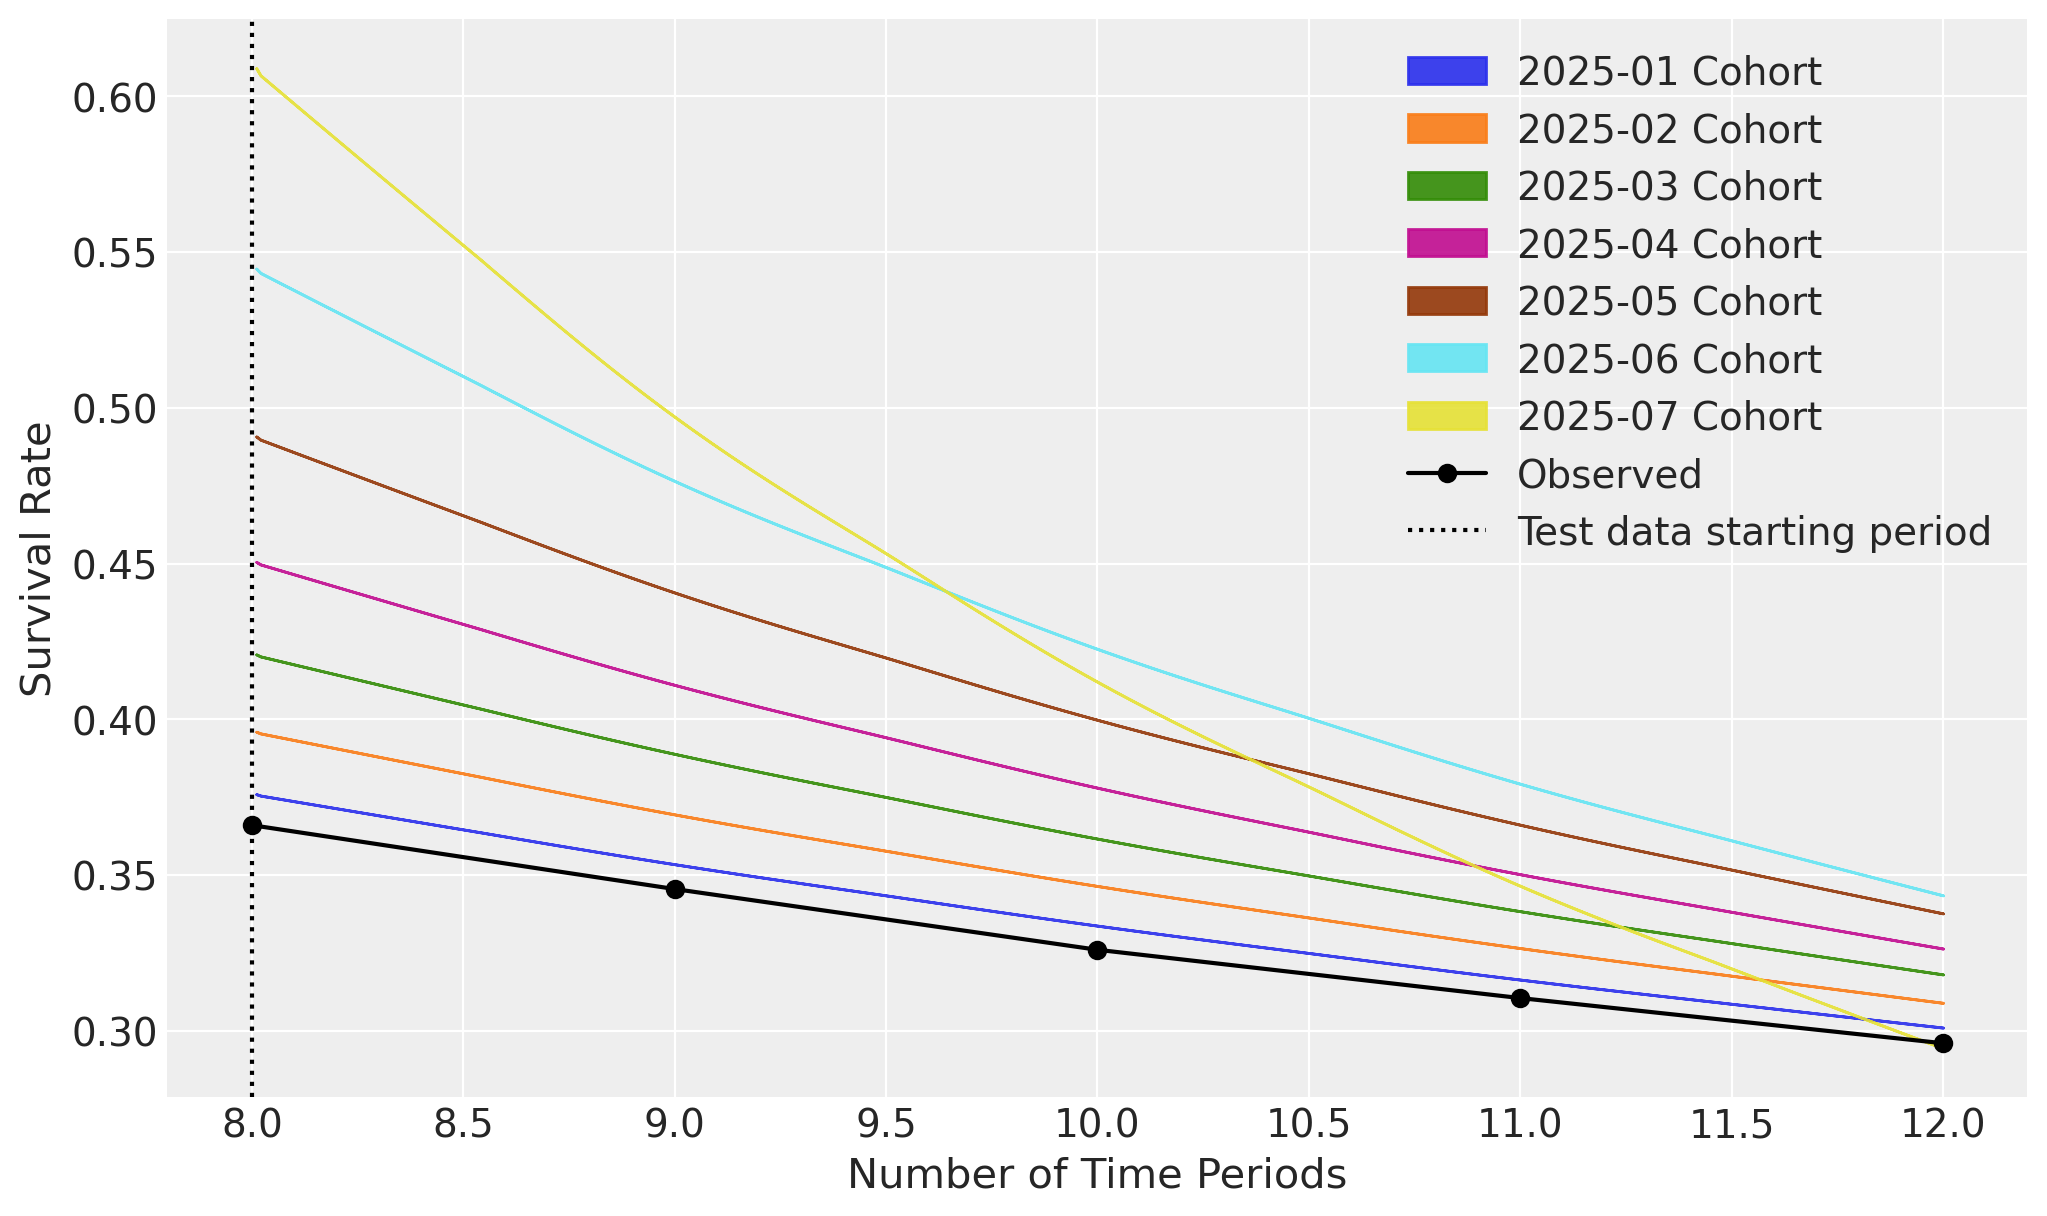

In [298]:
expected_survival_rates = xr.concat(
    objs=[
        sbg_full_map.expected_probability_alive(
            future_t=T,
        )
        for T in range(test_T - train_T)
    ],
    dim="T",
).transpose(..., "T")

monthly_cohorts = sorted(monthly_cohort_dataset['cohort'].unique())

for i, month in enumerate(monthly_cohorts):
    az.plot_hdi(
            range(train_T,test_T),
            expected_survival_rates.sel(cohort=month).mean("cohort"),
            hdi_prob=0.94,
            color=f"C{i}",
            fill_kwargs={"alpha": 0.9, "label": f"{month} Cohort"},
        )

plt.plot(range(train_T,test_T), test_array[train_T-1:], marker='o',color="k", label="Observed")
# plt.plot(range(1, test_T), retention_rate_regular_obs, marker='o', color="k")
plt.ylabel("Survival Rate")
plt.xlabel("Number of Time Periods")
plt.axvline(8, ls=":", color="k", label="Test data starting period")
plt.legend()
# plt.suptitle("Retention Rates over Time by Cohort",fontsize=18)
# plt.title("94% HDI Intervals",fontsize=12);

In [301]:
sbg_full = clv.ShiftedBetaGeoModel(
    data=monthly_cohort_dataset,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg_full.fit(method='mcmc',nuts_sampler="nutpie")

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

Warmup iterations saved (warmup_*).

In [159]:
# covar parameters are good heuristic for true parameters
sbg_covar.fit_summary(var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

mean     sd  hdi_3%  hdi_97%  \
alpha_scale[population]                      0.713  0.066   0.590    0.835   
beta_scale[population]                       1.204  0.154   0.928    1.495   
dropout_coefficient_alpha[highend_customer]  0.075  0.174  -0.263    0.378   
dropout_coefficient_beta[highend_customer]  -1.138  0.231  -1.580   -0.731   

                                             mcse_mean  mcse_sd  ess_bulk  \
alpha_scale[population]                          0.002    0.001    1124.0   
beta_scale[population]                           0.005    0.003    1048.0   
dropout_coefficient_alpha[highend_customer]      0.005    0.004    1160.0   
dropout_coefficient_beta[highend_customer]       0.007    0.004    1084.0   

                                             ess_tail  r_hat  
alpha_scale[population]                        1479.0   1.01  
beta_scale[population]                         1346.0   1.01  
dropout_coefficient_alpha[highend_customer]    1480.0   1.00  
dropout_coefficient_beta[highend_customer]     1531.0   1.00

In [305]:
sbg_full.fit_summary(var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

mean      sd  hdi_3%  hdi_97%  \
alpha_scale[2025-01]                         0.670   0.058   0.568    0.779   
alpha_scale[2025-02]                         0.701   0.063   0.582    0.816   
alpha_scale[2025-03]                         0.739   0.075   0.602    0.880   
alpha_scale[2025-04]                         0.793   0.095   0.621    0.970   
alpha_scale[2025-05]                         0.859   0.133   0.631    1.106   
alpha_scale[2025-06]                         1.009   0.296   0.592    1.540   
alpha_scale[2025-07]                         2.780  14.442   0.328    6.488   
beta_scale[2025-01]                          1.126   0.129   0.907    1.374   
beta_scale[2025-02]                          1.181   0.140   0.930    1.451   
beta_scale[2025-03]                          1.248   0.165   0.949    1.554   
beta_scale[2025-04]                          1.339   0.198   0.988    1.711   
beta_scale[2025-05]                          1.456   0.268   1.002    1.968   
beta_scale[2025-06]                          1.746   0.567   0.944    2.755   
beta_scale[2025-07]                          4.925  25.846   0.618   11.200   
dropout_coefficient_alpha[highend_customer] -0.163   0.109  -0.369    0.035   
dropout_coefficient_beta[highend_customer]  -1.417   0.130  -1.640   -1.154   

                                             mcse_mean  mcse_sd  ess_bulk  \
alpha_scale[2025-01]                             0.001    0.001    3712.0   
alpha_scale[2025-02]                             0.001    0.001    3405.0   
alpha_scale[2025-03]                             0.001    0.001    3871.0   
alpha_scale[2025-04]                             0.001    0.001    4109.0   
alpha_scale[2025-05]                             0.002    0.002    4530.0   
alpha_scale[2025-06]                             0.005    0.011    5013.0   
alpha_scale[2025-07]                             0.287    2.451    5022.0   
beta_scale[2025-01]                              0.002    0.002    3362.0   
beta_scale[2025-02]                              0.002    0.002    3298.0   
beta_scale[2025-03]                              0.003    0.003    3453.0   
beta_scale[2025-04]                              0.003    0.003    3554.0   
beta_scale[2025-05]                              0.004    0.005    4084.0   
beta_scale[2025-06]                              0.009    0.022    4663.0   
beta_scale[2025-07]                              0.515    4.382    4989.0   
dropout_coefficient_alpha[highend_customer]      0.003    0.002    1187.0   
dropout_coefficient_beta[highend_customer]       0.004    0.002    1166.0   

                                             ess_tail  r_hat  
alpha_scale[2025-01]                           3041.0    1.0  
alpha_scale[2025-02]                           2817.0    1.0  
alpha_scale[2025-03]                           3036.0    1.0  
alpha_scale[2025-04]                           3420.0    1.0  
alpha_scale[2025-05]                           3570.0    1.0  
alpha_scale[2025-06]                           3197.0    1.0  
alpha_scale[2025-07]                           2437.0    1.0  
beta_scale[2025-01]                            2563.0    1.0  
beta_scale[2025-02]                            2522.0    1.0  
beta_scale[2025-03]                            2857.0    1.0  
beta_scale[2025-04]                            2878.0    1.0  
beta_scale[2025-05]                            3290.0    1.0  
beta_scale[2025-06]                            3237.0    1.0  
beta_scale[2025-07]                            2485.0    1.0  
dropout_coefficient_alpha[highend_customer]    1568.0    1.0  
dropout_coefficient_beta[highend_customer]     1444.0    1.0

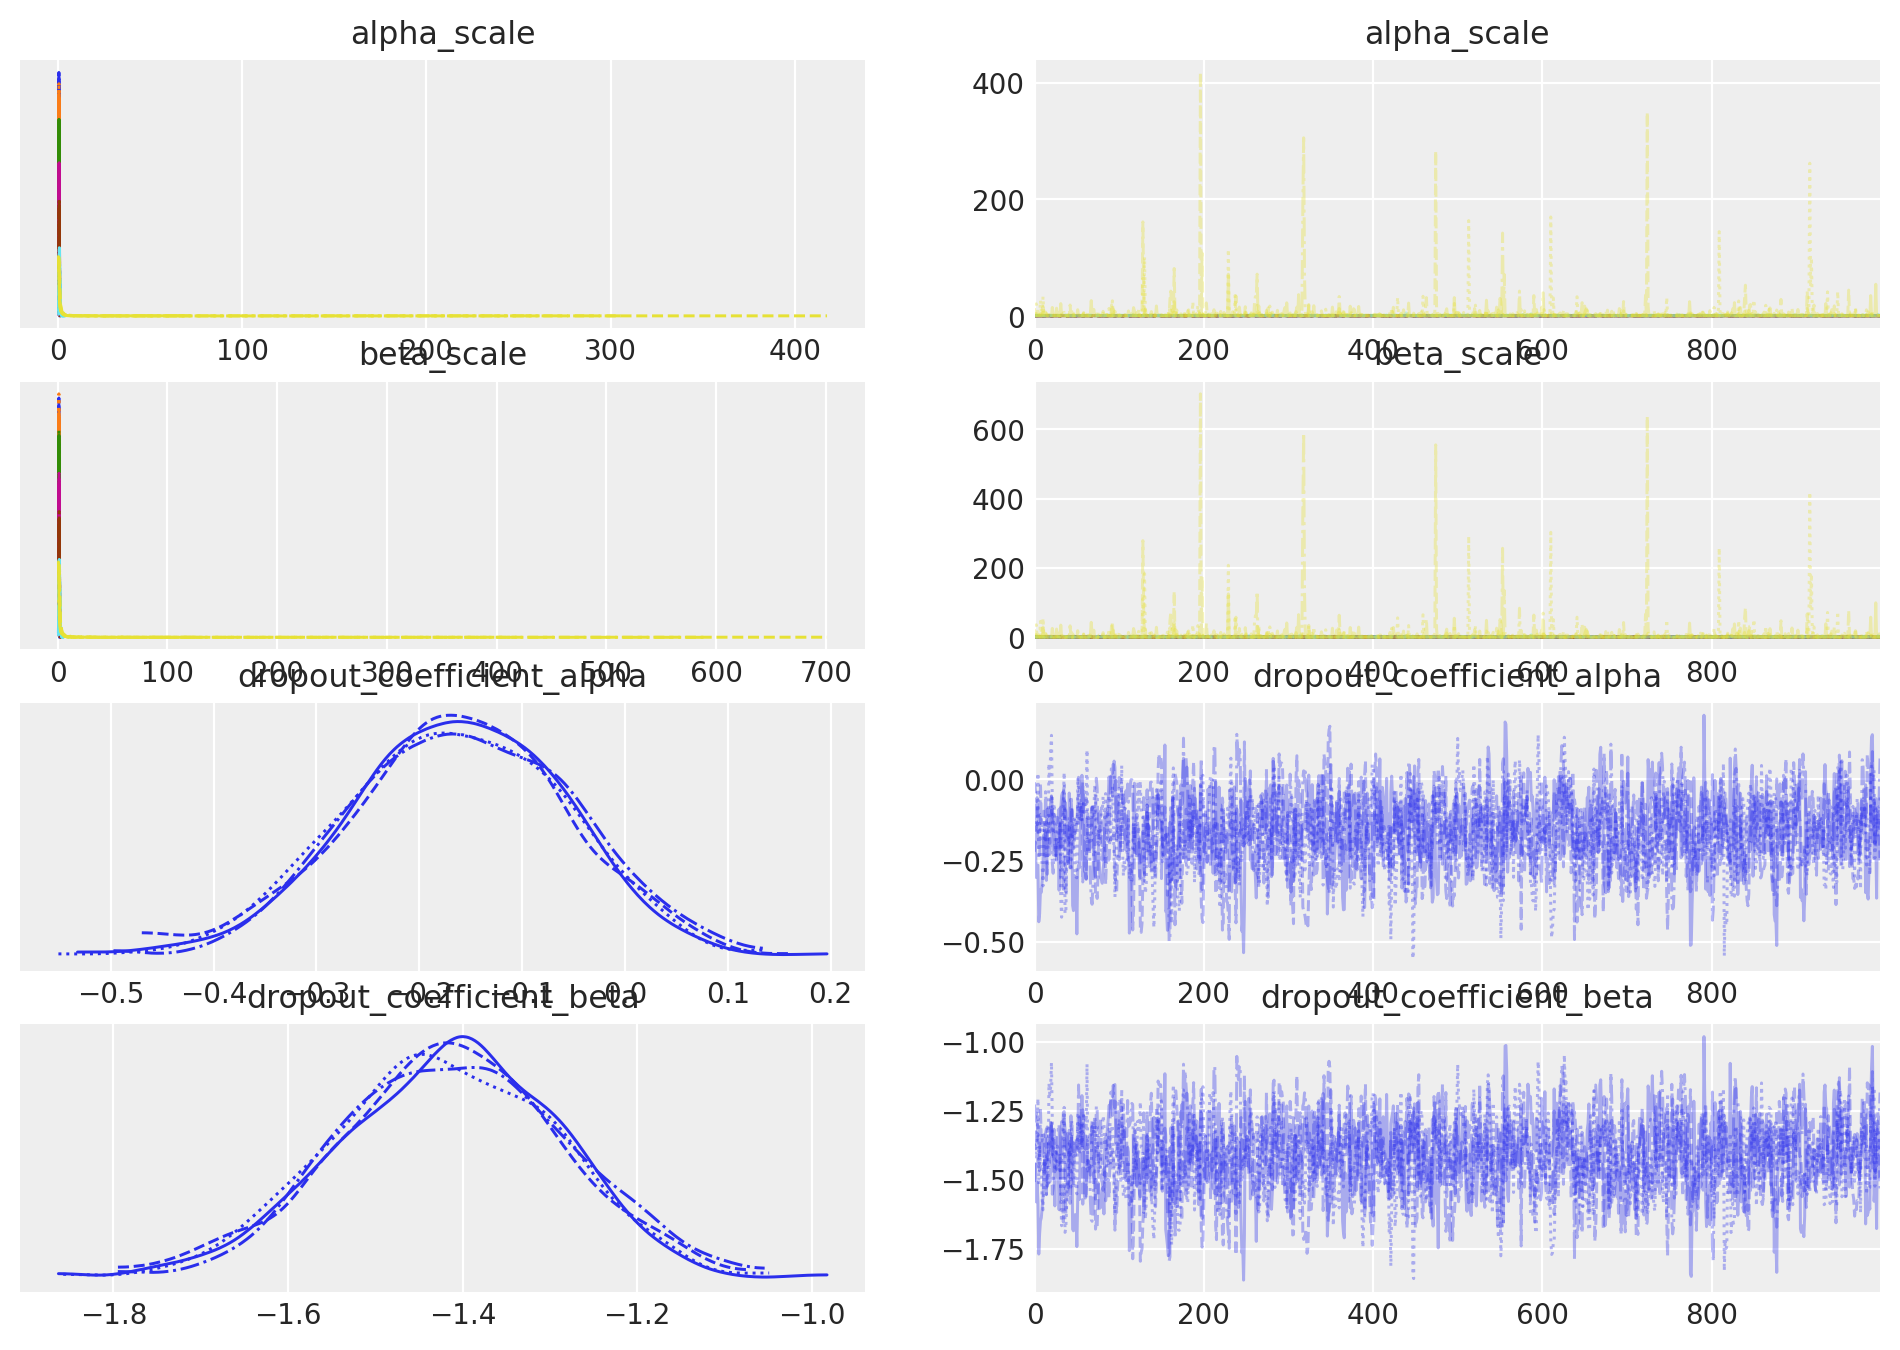

In [306]:
az.plot_trace(sbg_full.idata,var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"]);

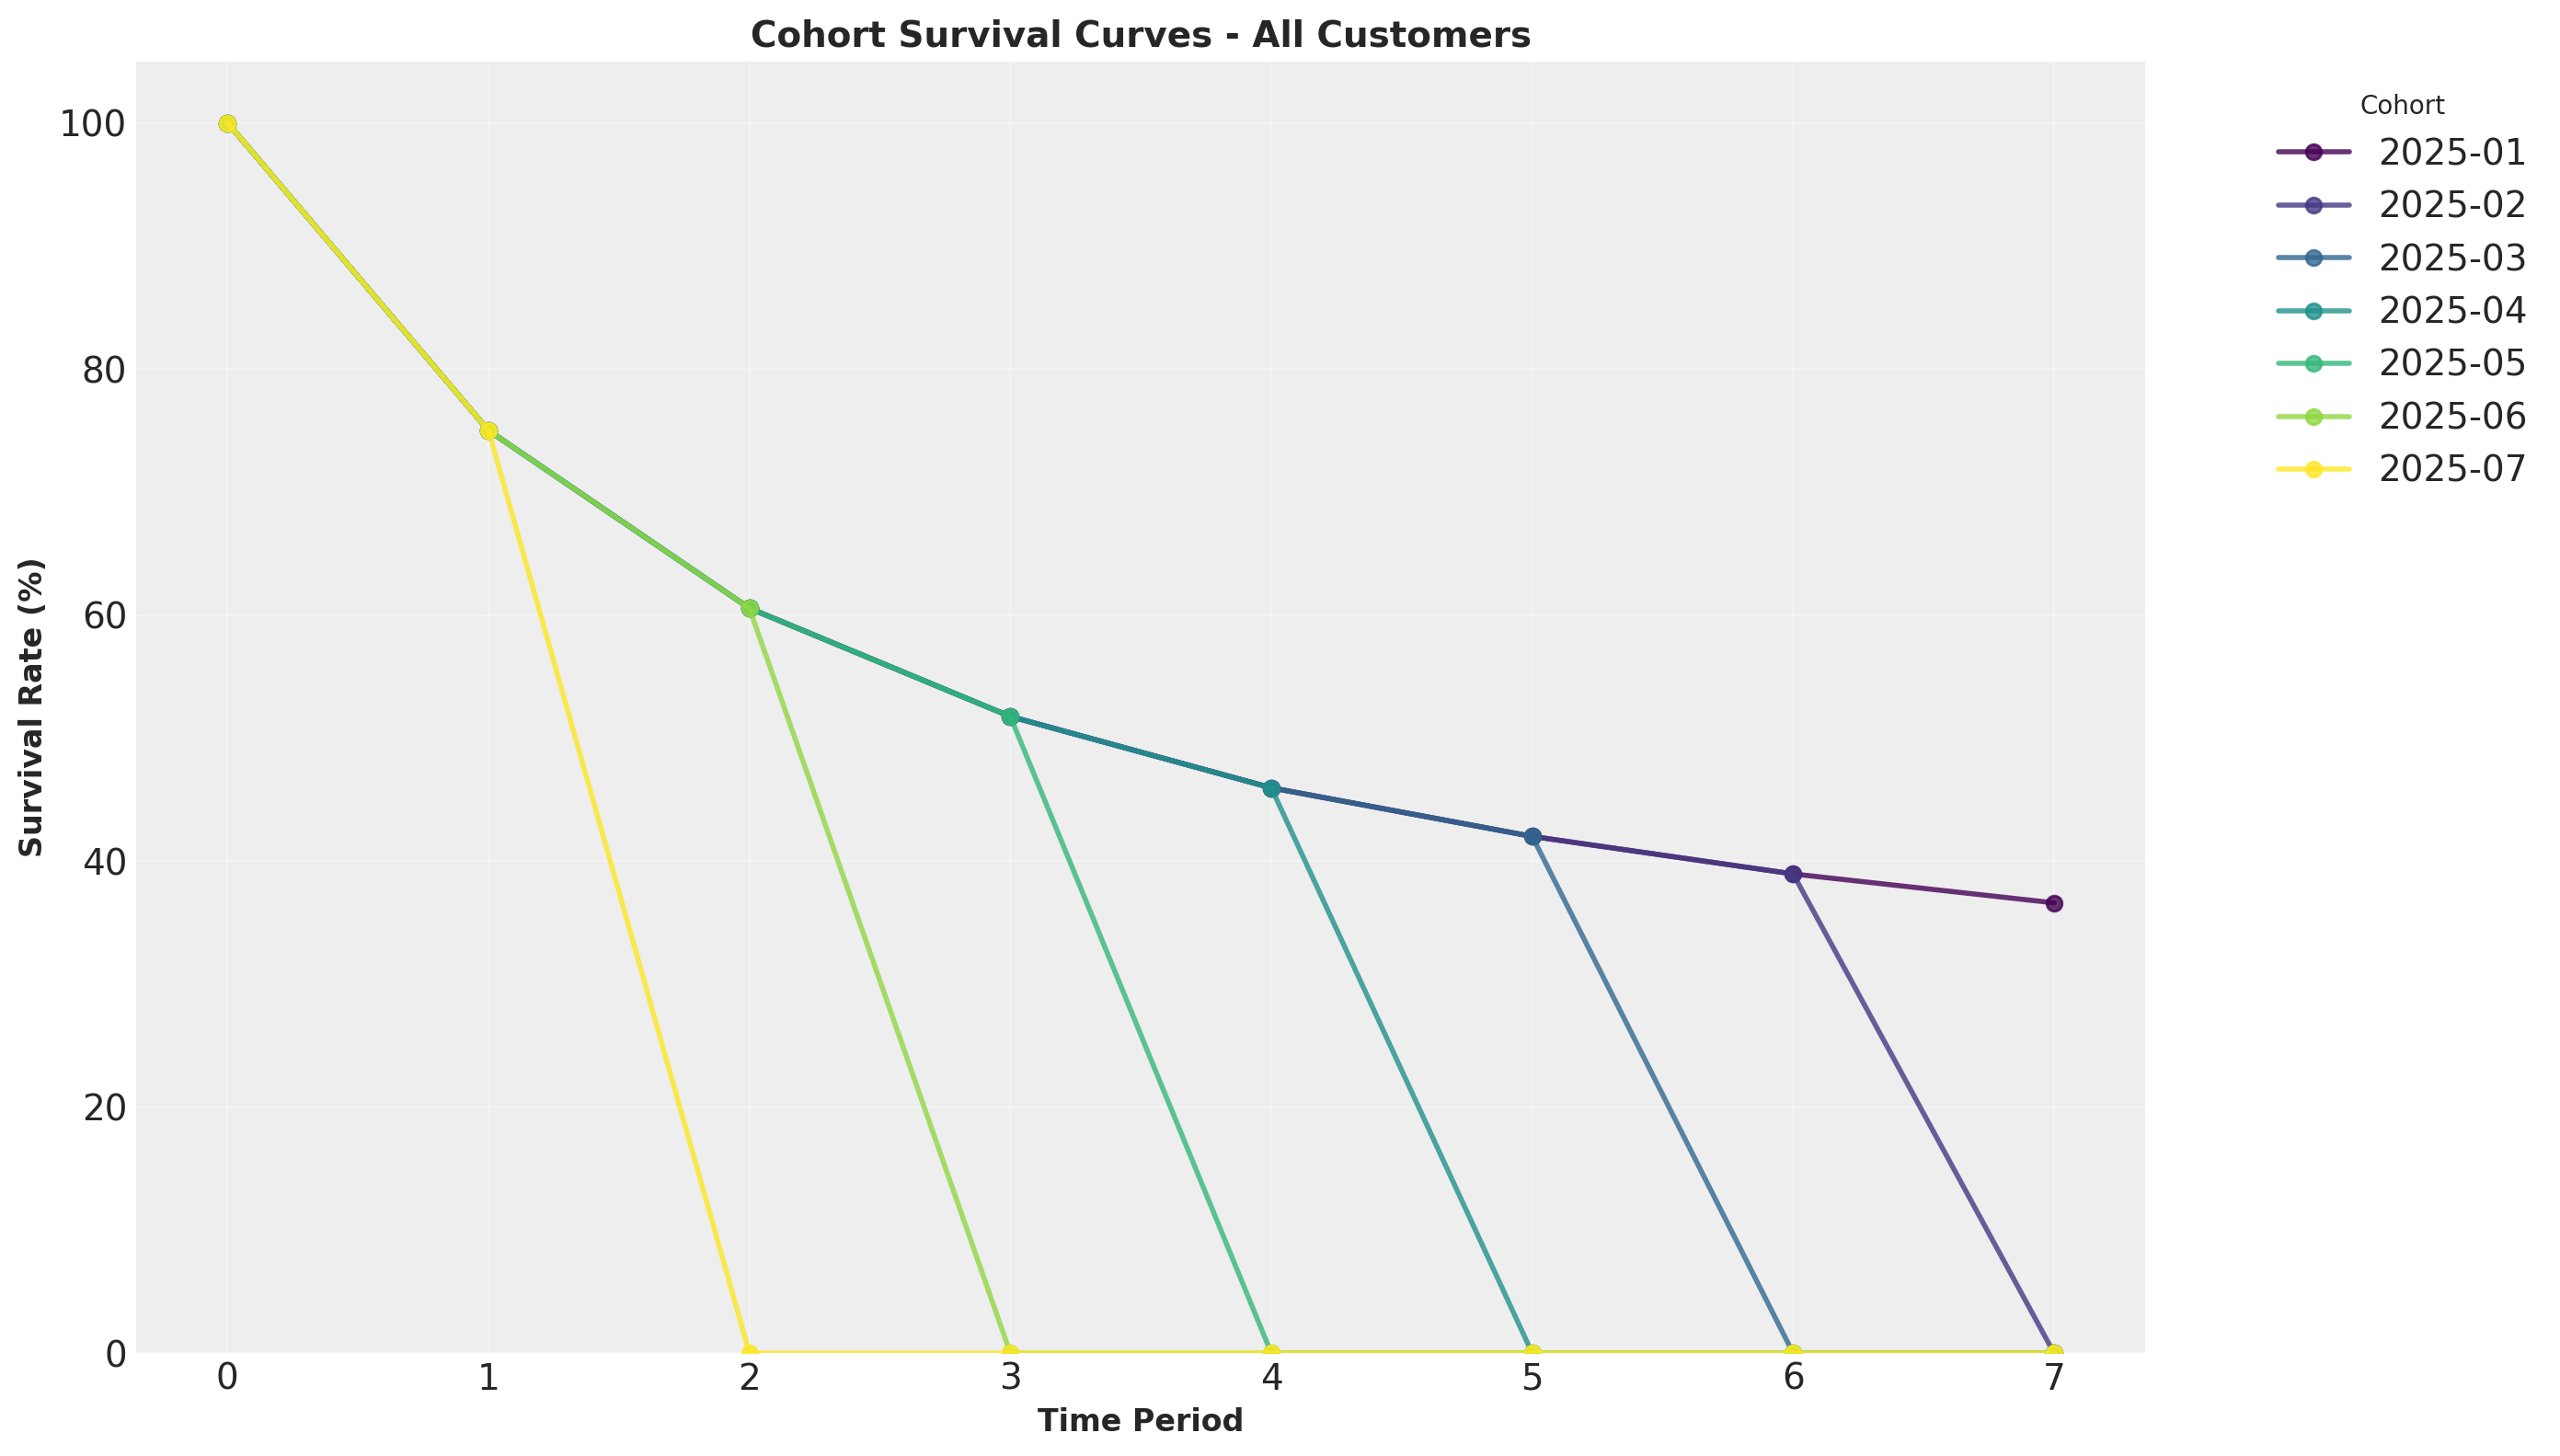

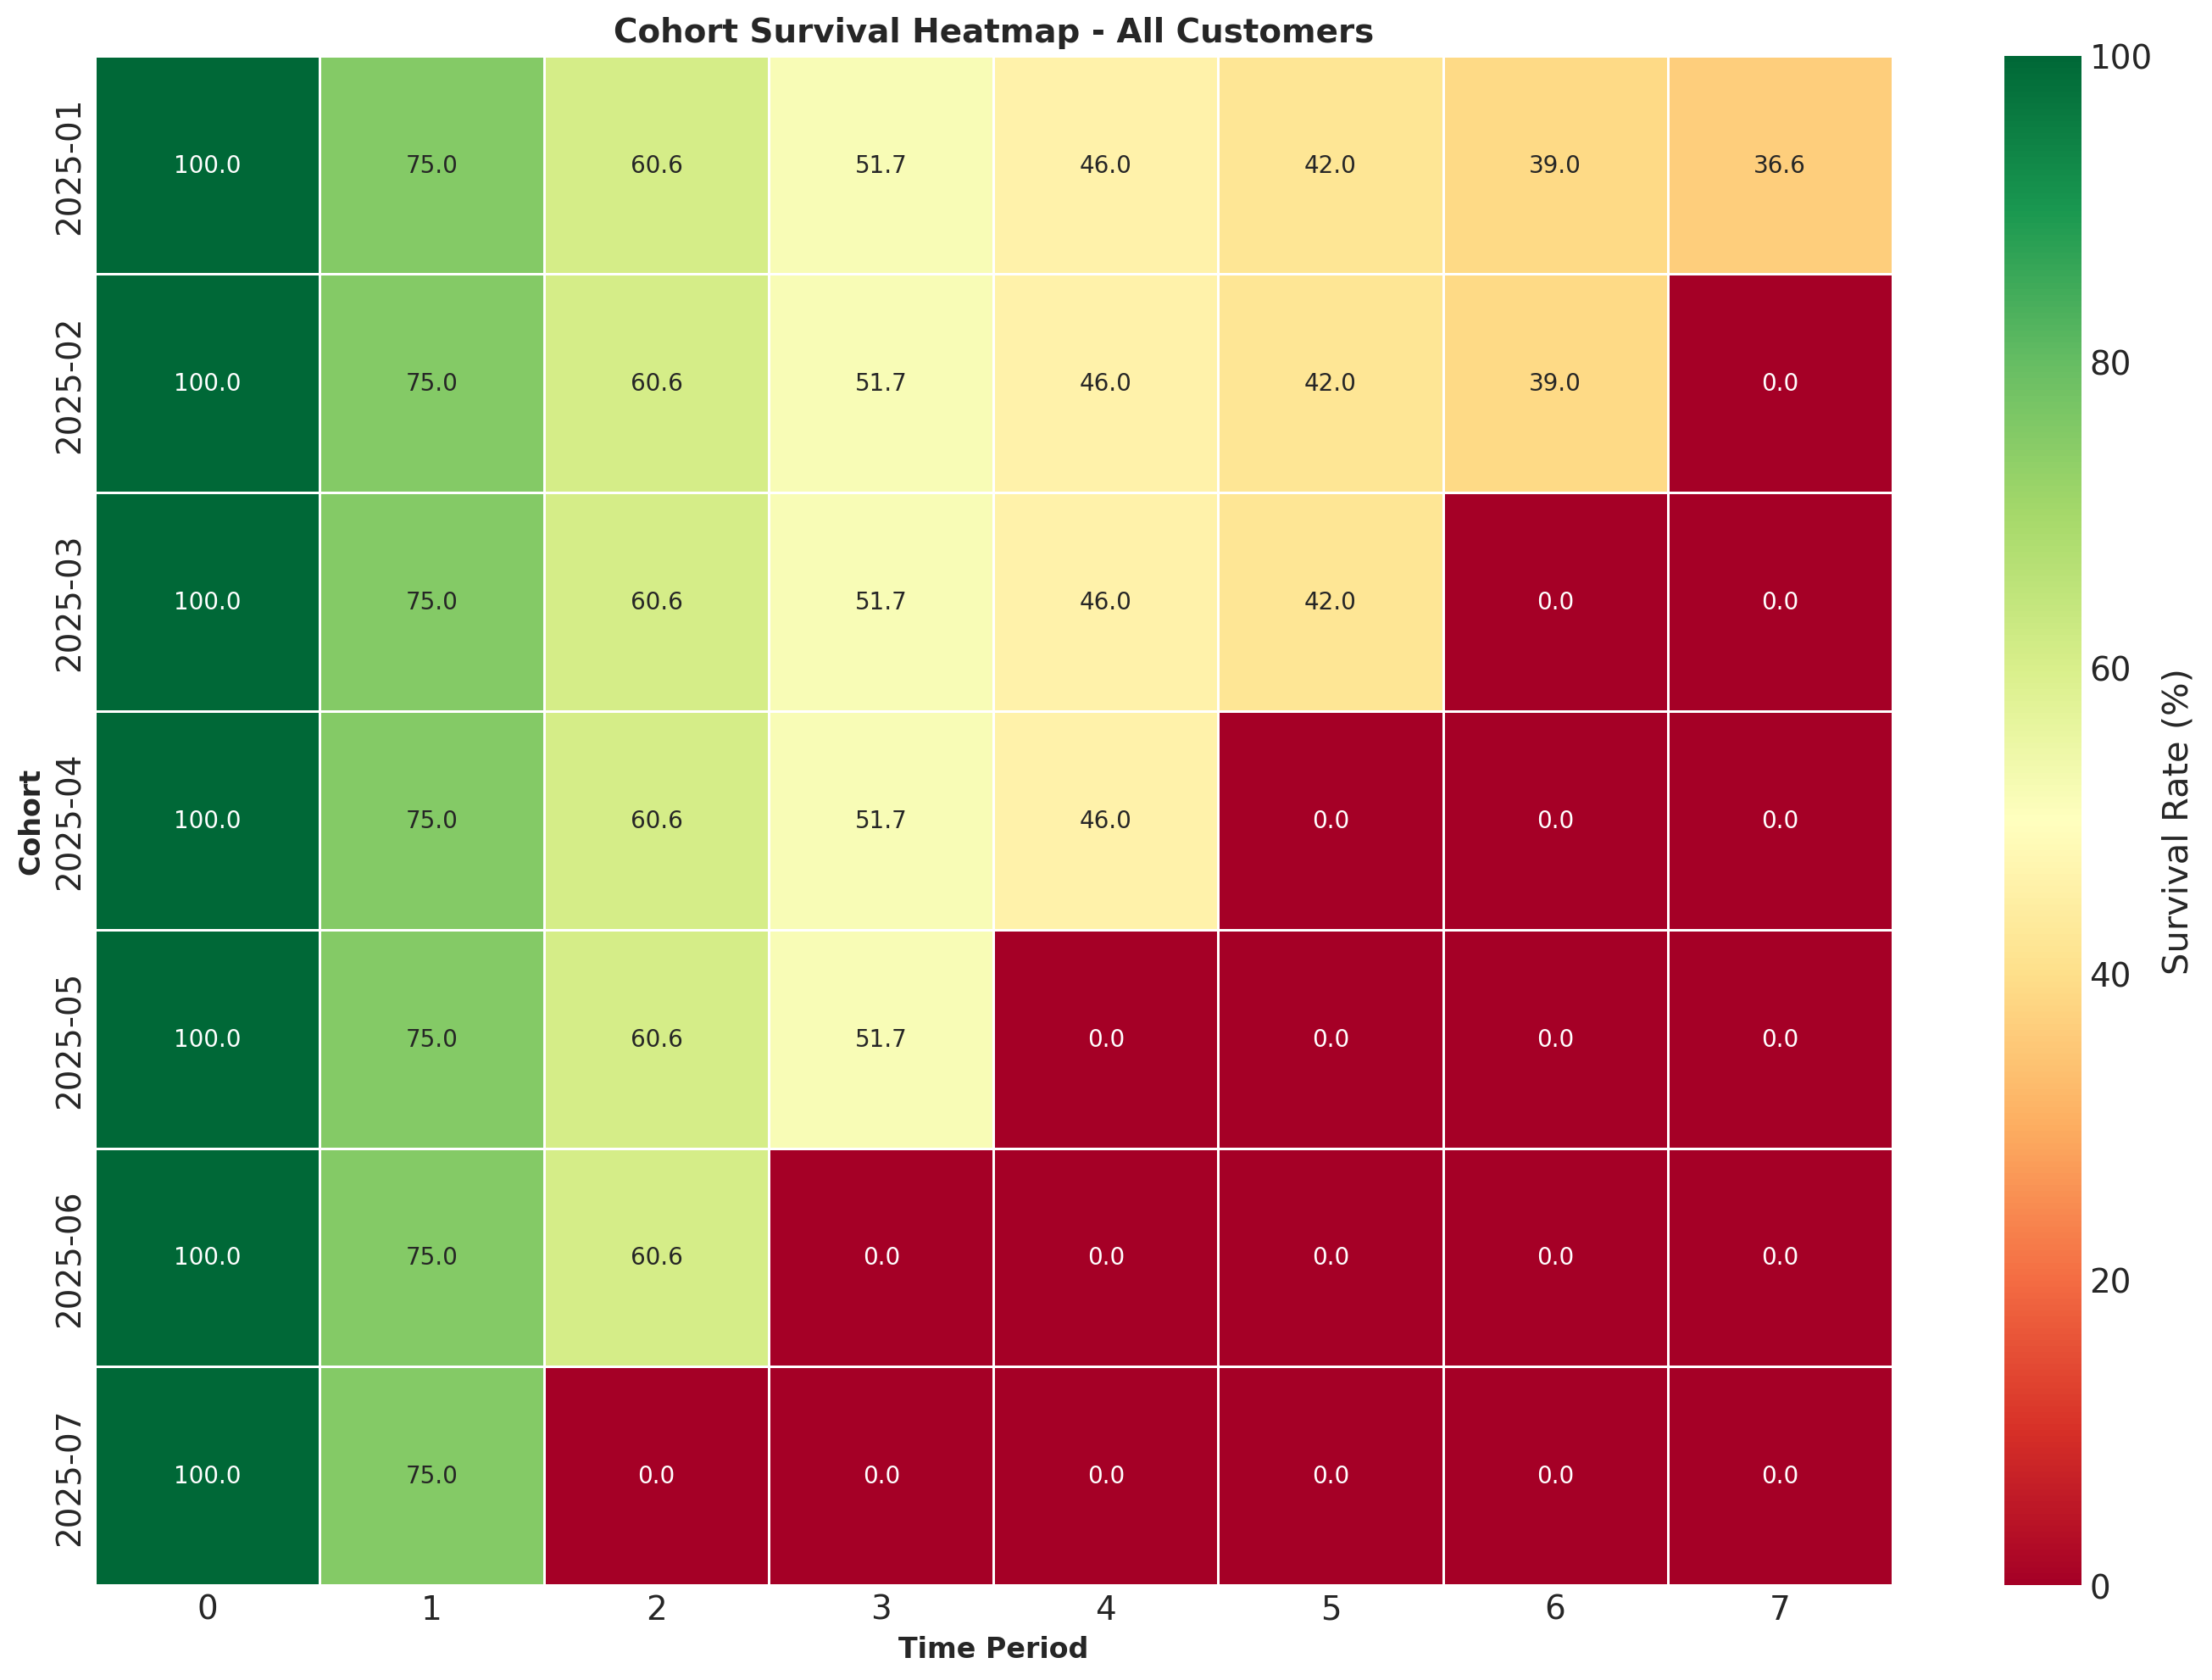

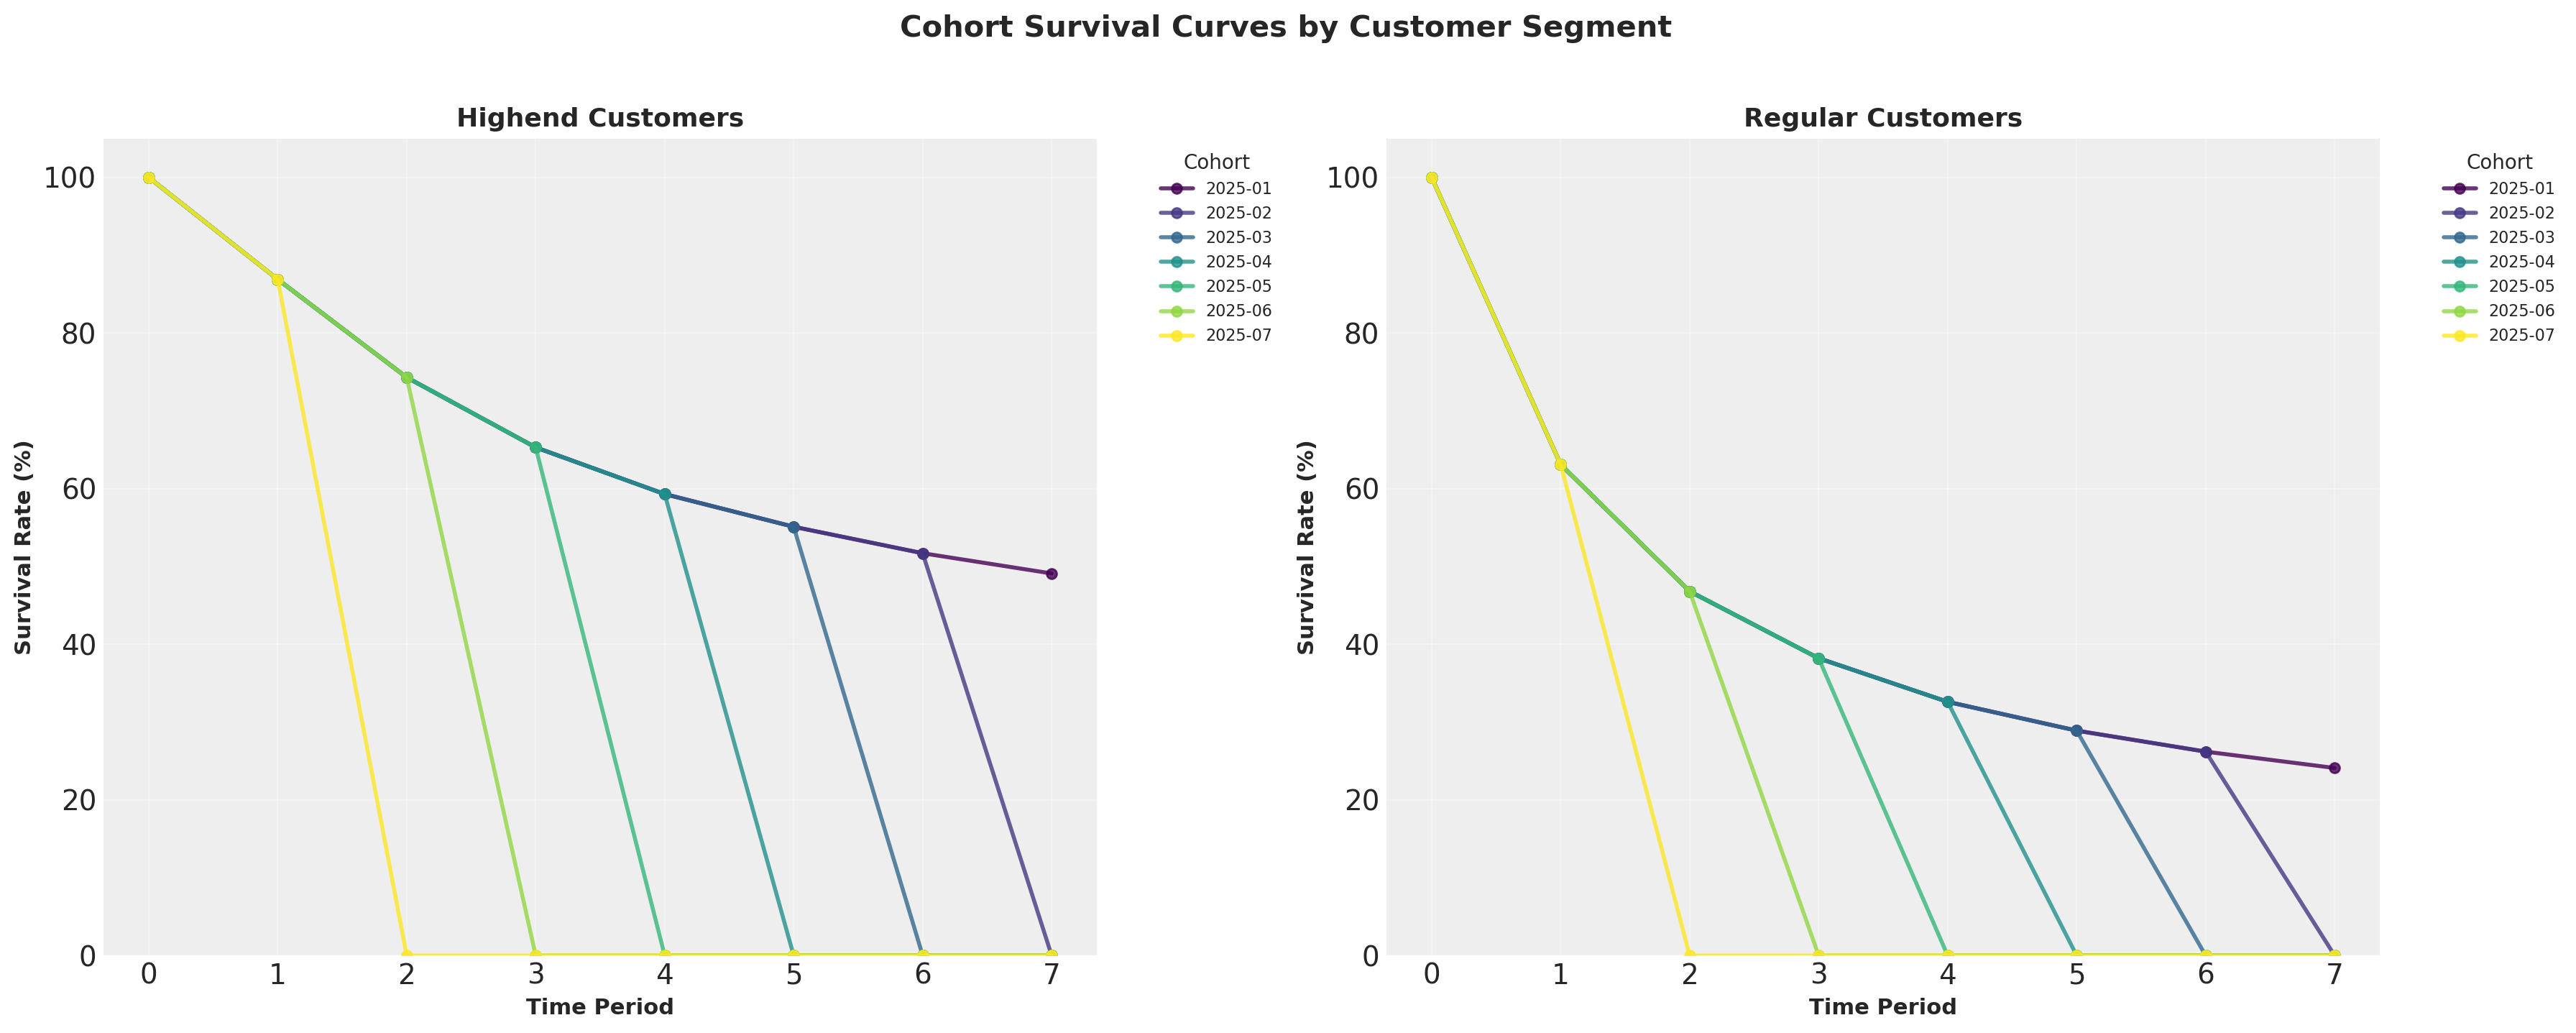

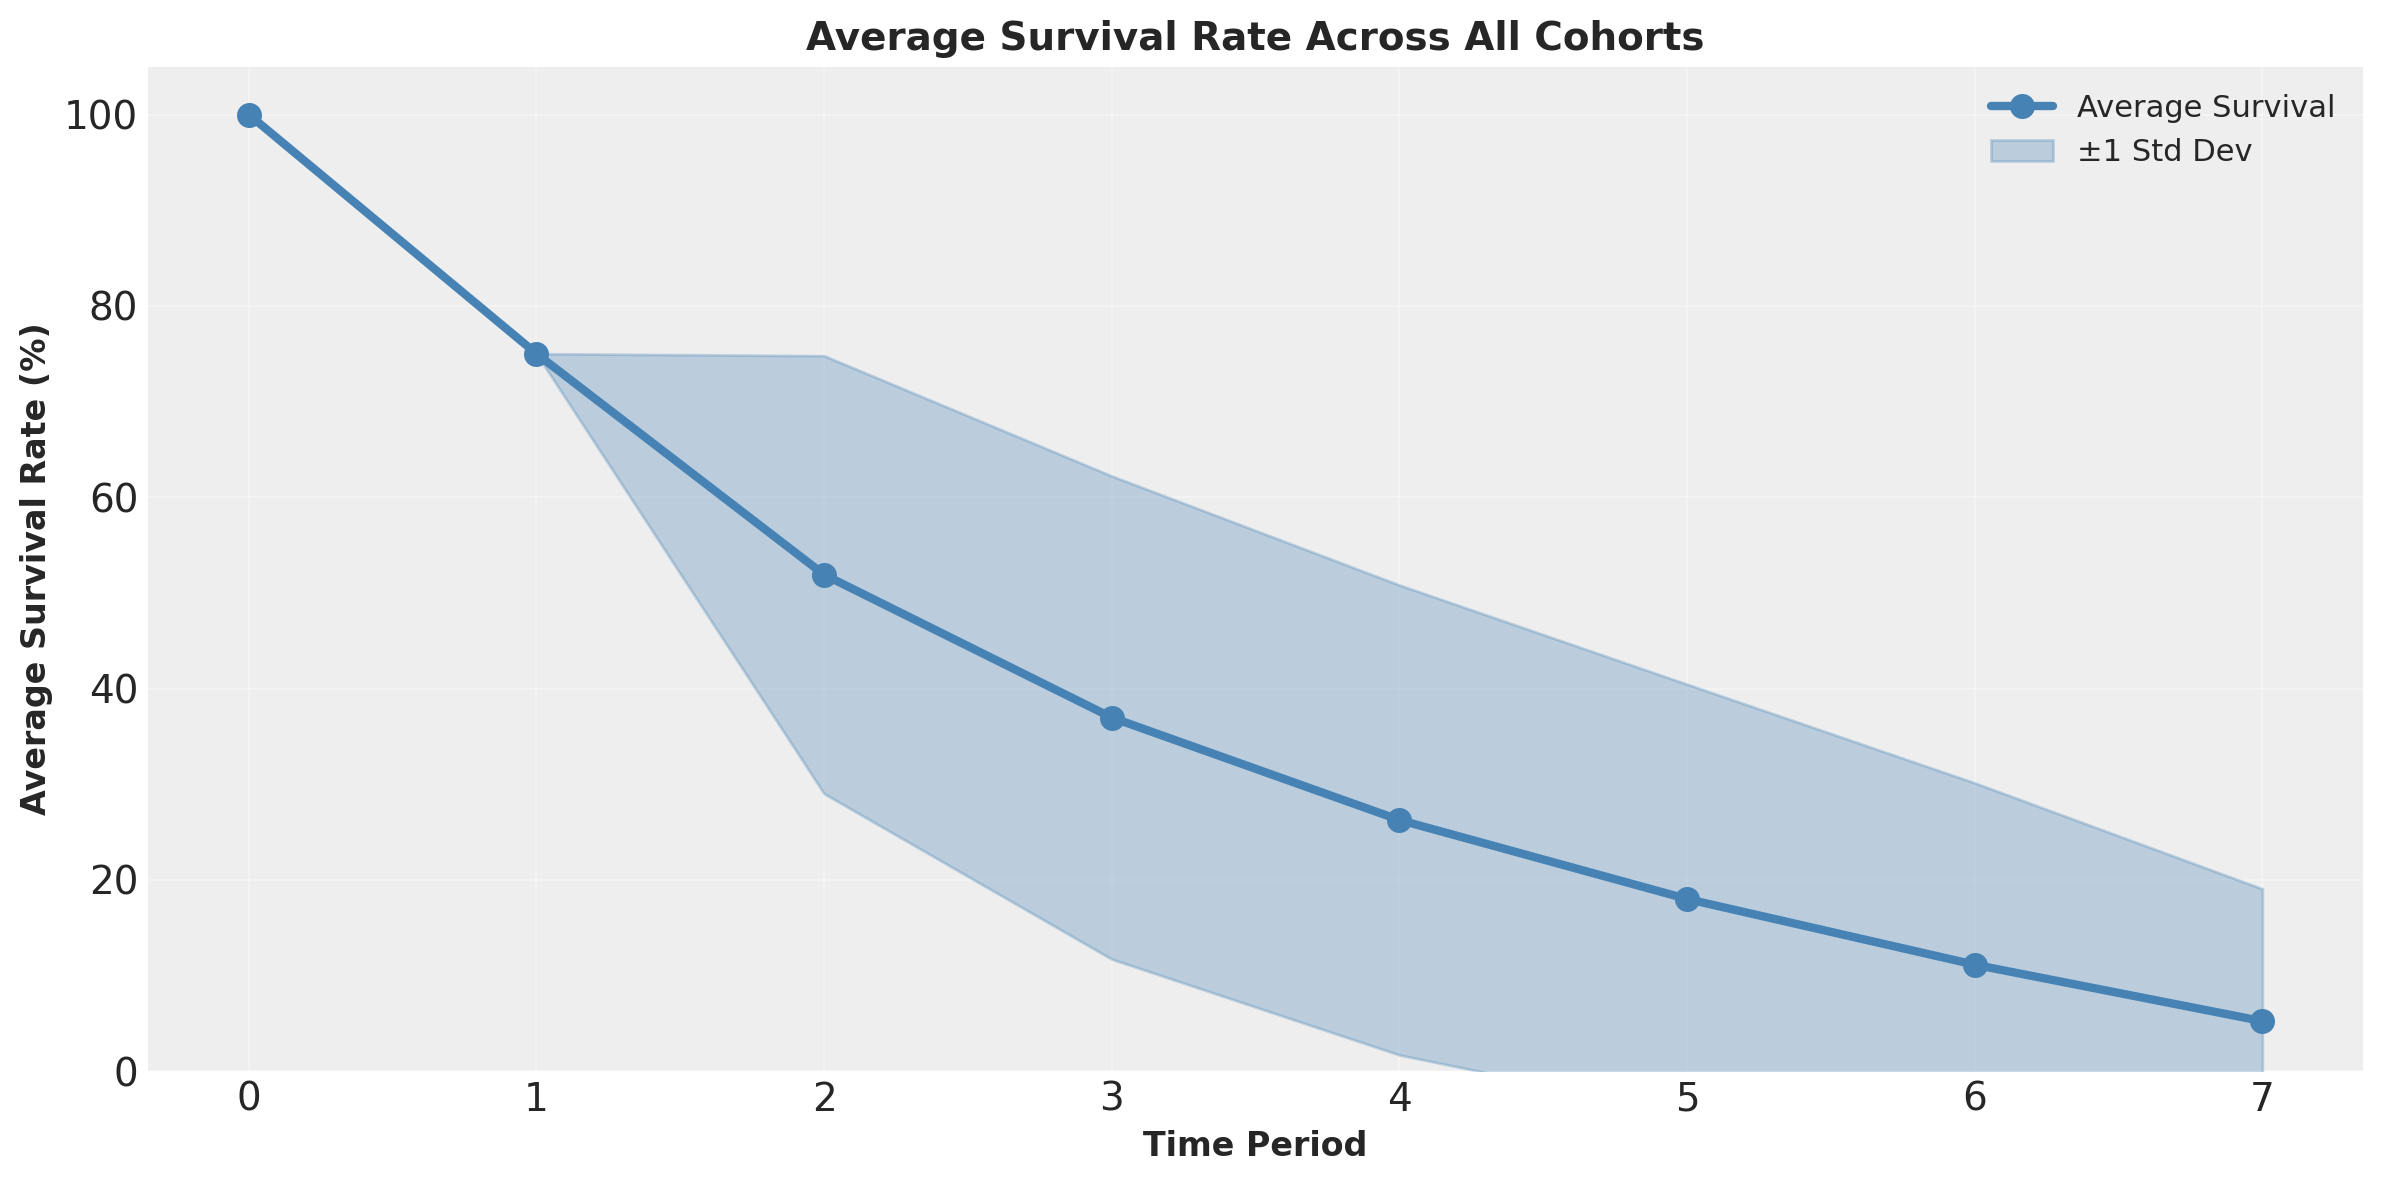

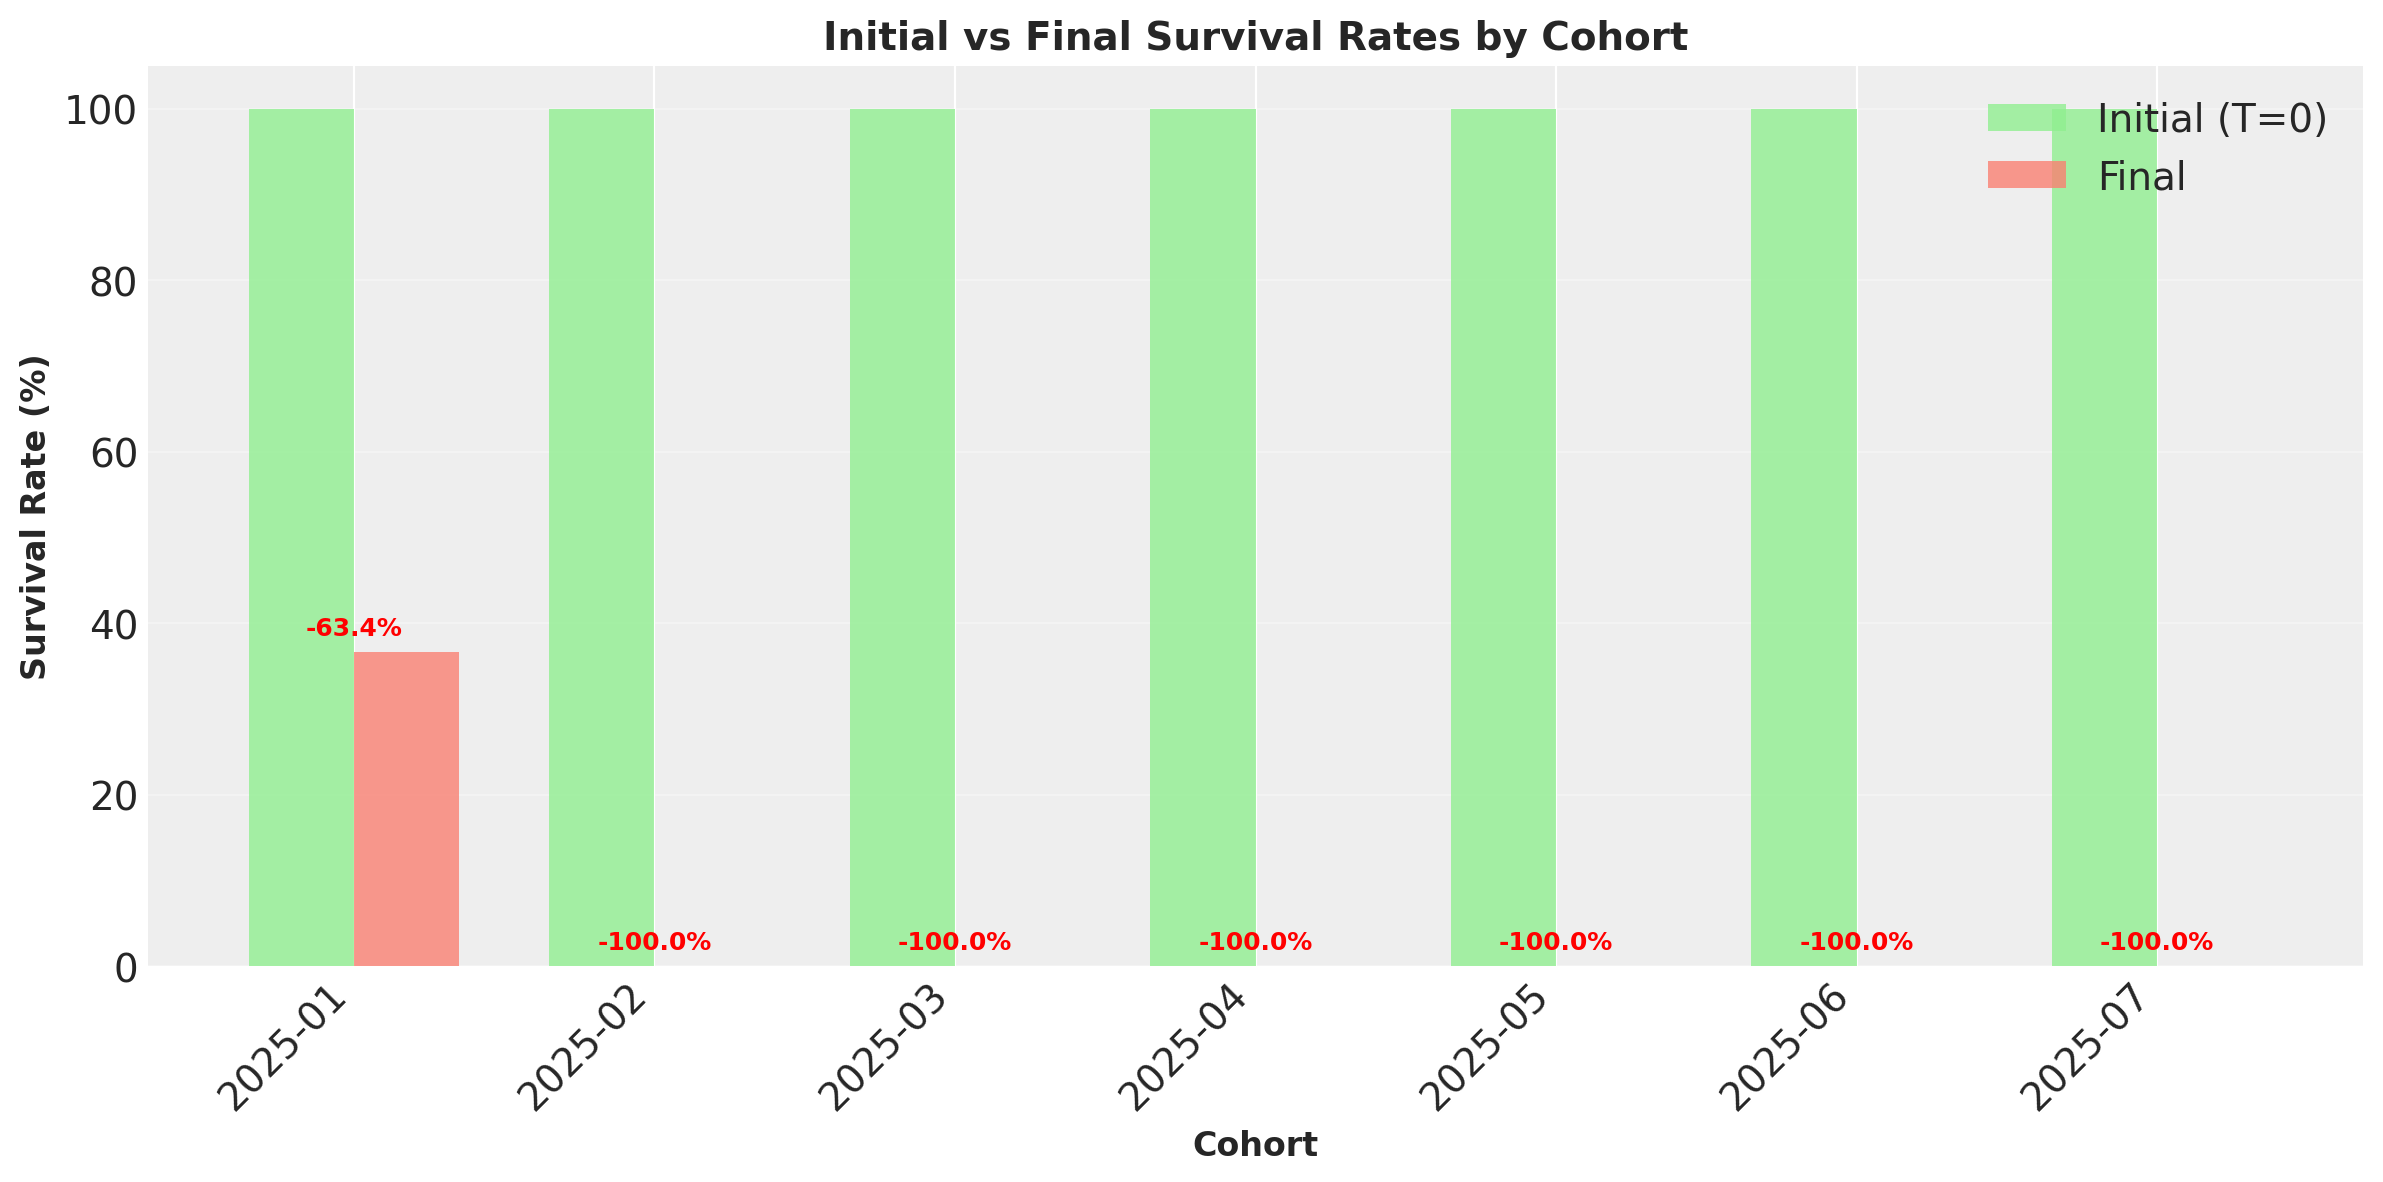


COHORT SURVIVAL ANALYSIS SUMMARY

2025-01:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 36.6%
  Survival Drop: 63.4%
  Estimated Remaining: 732

2025-02:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 0.0%
  Survival Drop: 100.0%
  Estimated Remaining: 0

2025-03:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 0.0%
  Survival Drop: 100.0%
  Estimated Remaining: 0

2025-04:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 0.0%
  Survival Drop: 100.0%
  Estimated Remaining: 0

2025-05:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 0.0%
  Survival Drop: 100.0%
  Estimated Remaining: 0

2025-06:
  Observation Periods: 7
  Total Customers: 2,000
  Initial Survival: 100.0%
  Final Survival: 0.0%
  Survival Drop: 100.0%
  Estimated Remaining: 0

2025-07:


In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# # Use the provided survival_rate_aggregation function
# def survival_rate_aggregation(customer_df: pd.DataFrame):
#     """Aggregate customer-level sBG data into survival rates by cohort over time for model testing."""
#     # Group by cohort to get total counts
#     cohort_totals = customer_df.groupby('cohort')['customer_id'].count()
#     cohorts = customer_df["cohort"].unique()
    
#     # Create a list to store results for each time period
#     results = []
    
#     # For each time period from 0 to T
#     for t in range(customer_df['T'].max() + 1):
#         row_data = {'T': t}
    
#         for cohort in cohorts:
#             cohort_data = customer_df[customer_df['cohort'] == cohort]
#             total_customers = len(cohort_data)
    
#             if t == 0:
#                 # At time 0, 100% retention
#                 retention_pct = 100.0
#             else:
#                 # Count customers who survived at least to time t (recency >= t)
#                 survived = len(cohort_data[cohort_data['recency'] >= t])
#                 retention_pct = (survived / total_customers) * 100
    
#             row_data[cohort] = retention_pct
    
#         results.append(row_data)
    
#     # Convert to DataFrame
#     return pd.DataFrame(results)


# Calculate survival rates for all customers
survival_df = survival_rate_aggregation(monthly_cohort_dataset)

# Calculate survival rates by segment
survival_highend = survival_rate_aggregation(
    monthly_cohort_dataset[monthly_cohort_dataset['highend_customer'] == 1]
)

survival_regular = survival_rate_aggregation(
    monthly_cohort_dataset[monthly_cohort_dataset['highend_customer'] == 0]
)


# ============= PLOT 1: Cohort Survival Curves =============
fig, ax = plt.subplots(figsize=(14, 8))

# Get monthly cohort columns (exclude 'T' column)
monthly_cohorts = [col for col in survival_df.columns if col.startswith('2025-')]
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_cohorts)))

for i, cohort in enumerate(sorted(monthly_cohorts)):
    # Filter out NaN values (cohorts don't have data for all time periods)
    cohort_data = survival_df[['T', cohort]].dropna()
    ax.plot(cohort_data['T'], cohort_data[cohort], 
            marker='o', linewidth=2, markersize=6, 
            label=cohort, color=colors[i], alpha=0.8)

ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Cohort Survival Curves - All Customers', fontsize=14, fontweight='bold')
ax.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


# ============= PLOT 2: Cohort Survival Heatmap =============
# Transpose to get cohorts as rows and time periods as columns
cohort_matrix = survival_df.set_index('T')[monthly_cohorts].T

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cohort_matrix, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Survival Rate (%)'}, 
            vmin=0, vmax=100, linewidths=0.5, ax=ax)
ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Cohort', fontsize=12, fontweight='bold')
ax.set_title('Cohort Survival Heatmap - All Customers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ============= PLOT 3: Segment Comparison =============
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Highend segment
monthly_cohorts_highend = [col for col in survival_highend.columns if col.startswith('2025-')]
for i, cohort in enumerate(sorted(monthly_cohorts_highend)):
    cohort_data = survival_highend[['T', cohort]].dropna()
    axes[0].plot(cohort_data['T'], cohort_data[cohort], 
                marker='o', linewidth=2, markersize=5, 
                label=cohort, color=colors[i], alpha=0.8)

axes[0].set_xlabel('Time Period', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Survival Rate (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Highend Customers', fontsize=13, fontweight='bold')
axes[0].legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 105)

# Regular segment
monthly_cohorts_regular = [col for col in survival_regular.columns if col.startswith('2025-')]
for i, cohort in enumerate(sorted(monthly_cohorts_regular)):
    cohort_data = survival_regular[['T', cohort]].dropna()
    axes[1].plot(cohort_data['T'], cohort_data[cohort], 
                marker='o', linewidth=2, markersize=5, 
                label=cohort, color=colors[i], alpha=0.8)

axes[1].set_xlabel('Time Period', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Survival Rate (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Regular Customers', fontsize=13, fontweight='bold')
axes[1].legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 105)

fig.suptitle('Cohort Survival Curves by Customer Segment', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# ============= PLOT 4: Average Survival by Period (All Cohorts) =============
# Calculate mean and std across cohorts for each time period
survival_stats = pd.DataFrame({
    'T': survival_df['T'],
    'mean_survival': survival_df[monthly_cohorts].mean(axis=1, skipna=True),
    'std_survival': survival_df[monthly_cohorts].std(axis=1, skipna=True),
    'n_cohorts': survival_df[monthly_cohorts].notna().sum(axis=1)
})

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(survival_stats['T'], survival_stats['mean_survival'], 
        marker='o', linewidth=3, markersize=8, color='steelblue', label='Average Survival')
ax.fill_between(survival_stats['T'], 
                survival_stats['mean_survival'] - survival_stats['std_survival'],
                survival_stats['mean_survival'] + survival_stats['std_survival'],
                alpha=0.3, color='steelblue', label='±1 Std Dev')

ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Average Survival Rate Across All Cohorts', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()


# ============= PLOT 5: Cohort Comparison - First vs Last Period =============
# Compare retention at first available period vs last period for each cohort
cohort_comparison = []
for cohort in monthly_cohorts:
    cohort_data = survival_df[['T', cohort]].dropna()
    if len(cohort_data) > 1:
        initial = cohort_data[cohort].iloc[0]
        final = cohort_data[cohort].iloc[-1]
        retention_drop = initial - final
        
        cohort_comparison.append({
            'Cohort': cohort,
            'Initial': initial,
            'Final': final,
            'Drop': retention_drop,
            'Periods': len(cohort_data) - 1
        })

comparison_df = pd.DataFrame(cohort_comparison)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Initial'], width, 
               label='Initial (T=0)', color='lightgreen', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Final'], width, 
               label='Final', color='salmon', alpha=0.8)

ax.set_xlabel('Cohort', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Initial vs Final Survival Rates by Cohort', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Cohort'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 105)

# Add drop percentage as text
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    ax.text(i, row['Final'] + 2, f'-{row["Drop"]:.1f}%', 
            ha='center', fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.show()


# ============= SUMMARY STATISTICS =============
print("\n" + "="*60)
print("COHORT SURVIVAL ANALYSIS SUMMARY")
print("="*60)

for cohort in sorted(monthly_cohorts):
    cohort_data = survival_df[['T', cohort]].dropna()
    if len(cohort_data) > 0:
        initial_survival = cohort_data[cohort].iloc[0]
        final_survival = cohort_data[cohort].iloc[-1]
        max_period = cohort_data['T'].max()
        
        # Get customer counts from original data
        cohort_customers = monthly_cohort_dataset[monthly_cohort_dataset['cohort'] == cohort]
        n_customers = len(cohort_customers)
        
        print(f"\n{cohort}:")
        print(f"  Observation Periods: {int(max_period)}")
        print(f"  Total Customers: {n_customers:,}")
        print(f"  Initial Survival: {initial_survival:.1f}%")
        print(f"  Final Survival: {final_survival:.1f}%")
        print(f"  Survival Drop: {initial_survival - final_survival:.1f}%")
        print(f"  Estimated Remaining: {int(n_customers * final_survival / 100):,}")

print("\n" + "="*60)

These additional predictive methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf

In [60]:
# filter dataset to only active customers
pred_data=dataset.query("recency==T")

# predict retention rate and convert to dataframe for downstream processing
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))
pred_cohort_retention.to_dataframe(name="retention").reset_index()

cohort  customer_id  retention
0    highend          510   0.942107
1    highend          511   0.942107
2    highend          512   0.942107
3    highend          513   0.942107
4    highend          514   0.942107
..       ...          ...        ...
727  regular         1996   0.920621
728  regular         1997   0.920621
729  regular         1998   0.920621
730  regular         1999   0.920621
731  regular         2000   0.920621

[732 rows x 3 columns]

### Latent Dropout Distribution for Customer Population
Plotting dropout distributions by cohort is more intuitive than the alpha and beta parameters for each, but the below code will require modification if model has not been fit with MAP:

Text(0.5, 1.0, 'Dropout Distributions by Cohort')

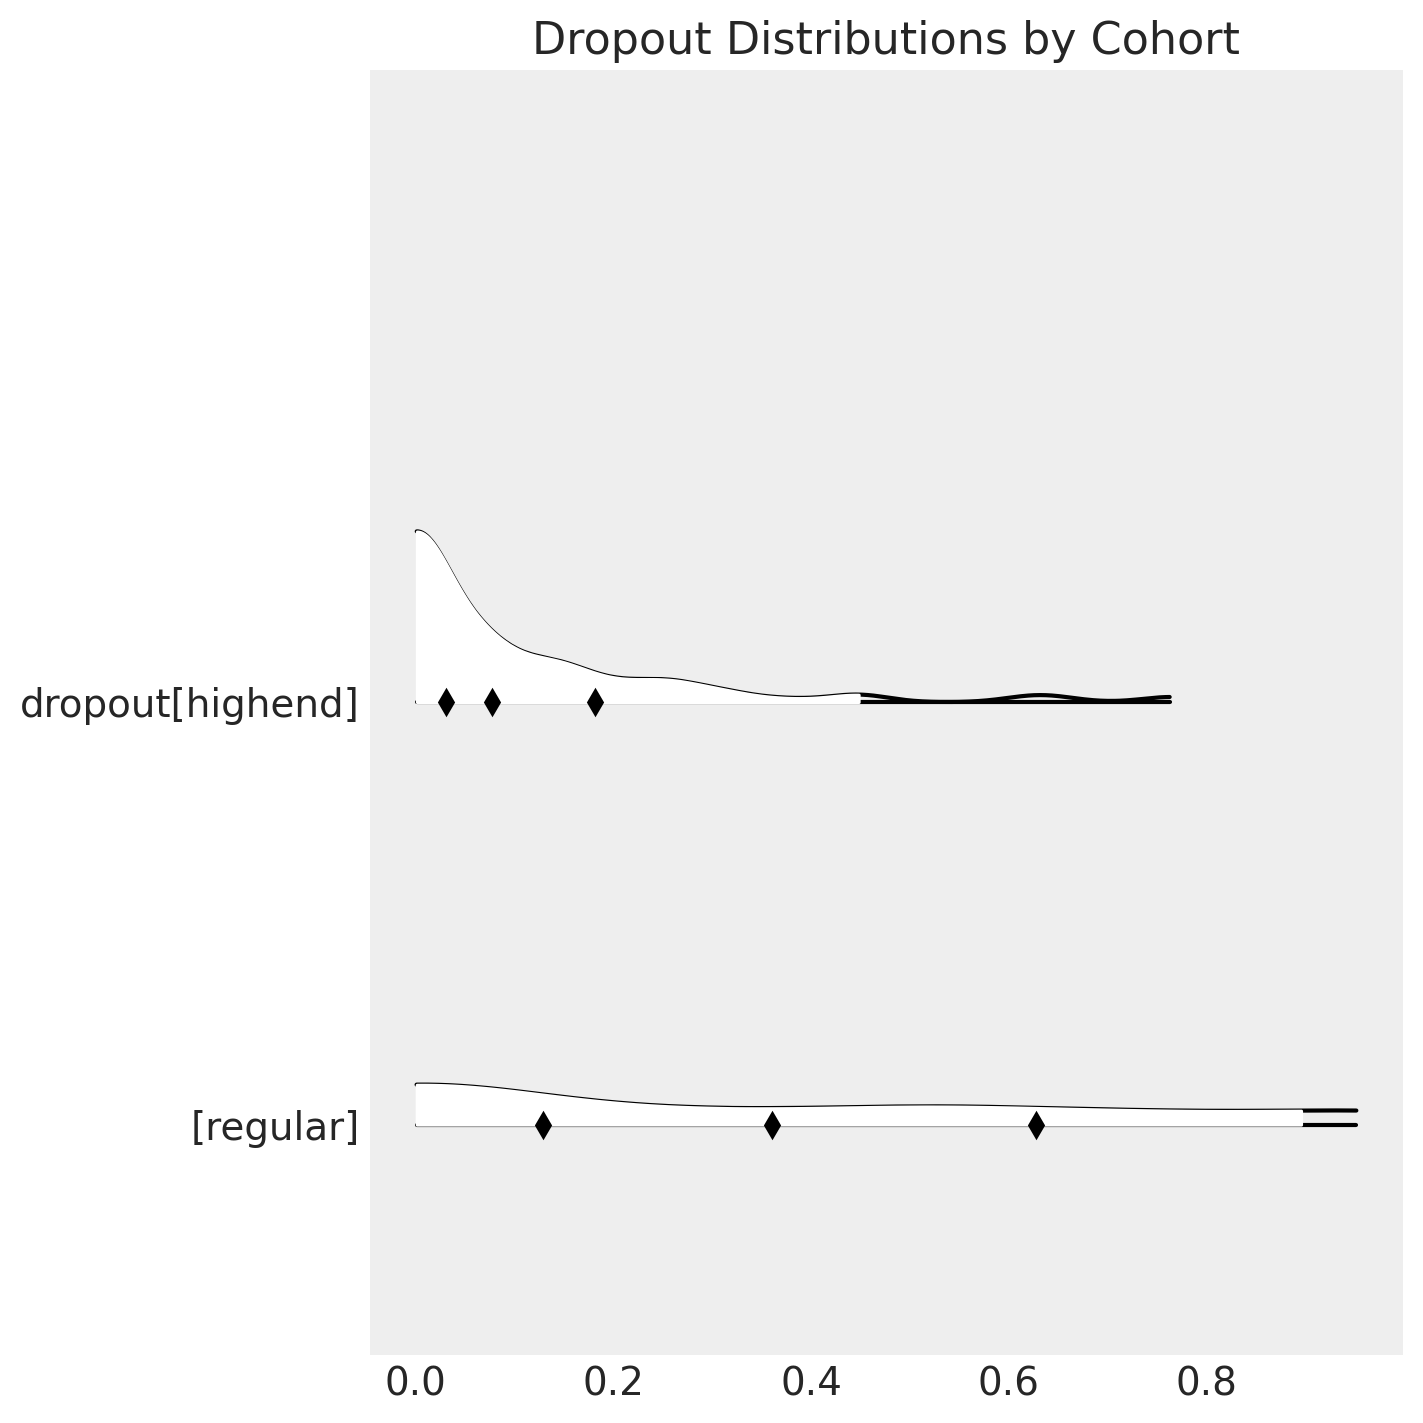

In [67]:
# Extract alpha and beta from fit results
alpha = sbg.fit_result["alpha"]
beta = sbg.fit_result["beta"]

# Generate 100 random samples from Beta distribution for each cohort
rng = np.random.default_rng(42)
n_samples = 100

cohorts = alpha.coords['cohort'].values
dropout_samples = np.array([
    rng.beta(
        alpha.sel(cohort=c).values.item(),  # Use .item() to get scalar
        beta.sel(cohort=c).values.item(),   # Use .item() to get scalar
        size=n_samples
    )
    for c in cohorts
]).T  # Transpose to get (samples, cohorts) shape

# Create xarray DataArray with chain, draw, and cohort dimensions
# Reshape to add chain dimension (1 chain, n_samples draws)
dropout = xr.DataArray(
    dropout_samples[np.newaxis, :, :],  # Add chain dimension
    dims=("chain", "draw", "cohort"),
    coords={
        "chain": [0],
        "draw": np.arange(n_samples),
        "cohort": cohorts,
    },
    name="dropout",
)

# Convert to InferenceData
dropout_idata = az.convert_to_inference_data(dropout)

# Plot with arviz
axes = az.plot_forest(
    dropout_idata,
    kind='ridgeplot',
    combined=True,
    colors='white',
    ridgeplot_overlap=1,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[.25,.5,.75],
    figsize=(7,7),
)
axes[0].set_title("Dropout Distributions by Cohort")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

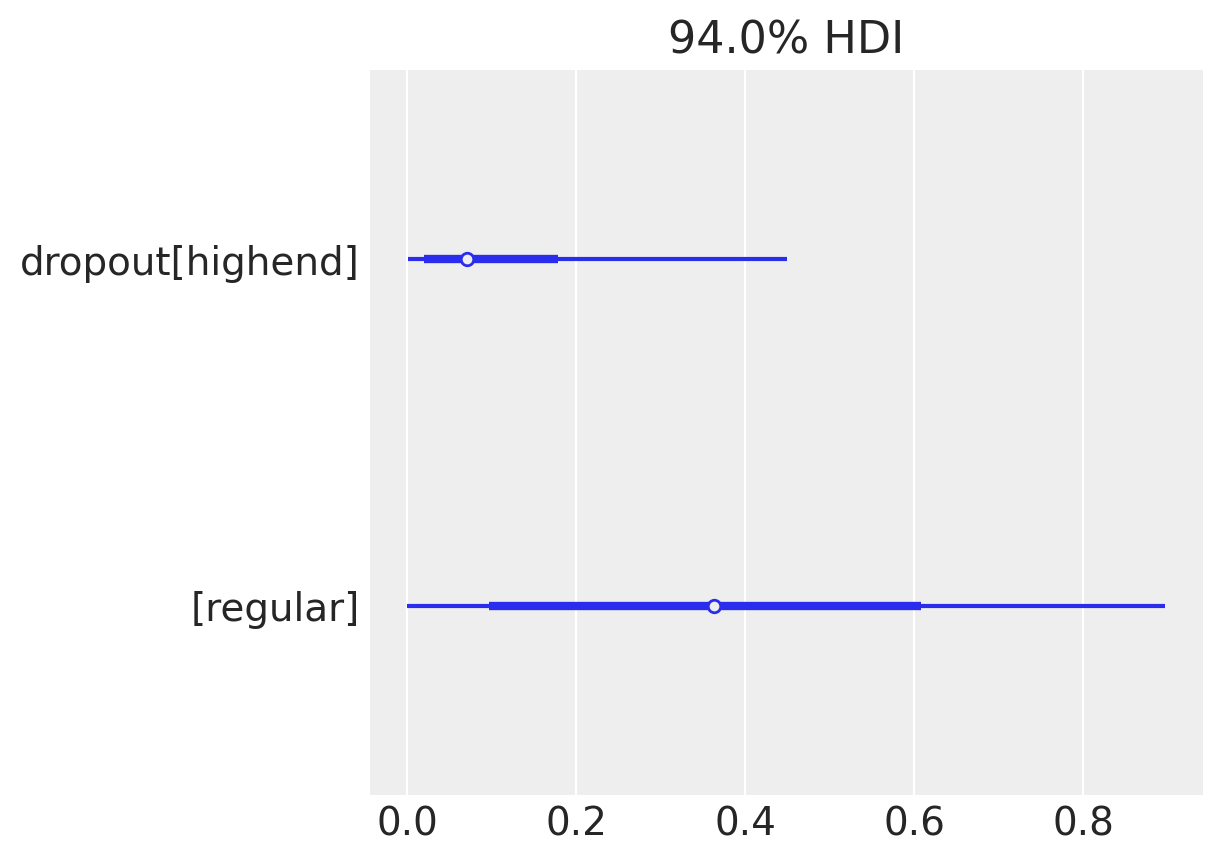

In [66]:
az.plot_forest(dropout_idata)

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Wed Nov 05 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc_extras   : 0.4.0
pytensor      : 2.31.7
pandas        : 2.3.1
pymc          : 5.25.1
arviz         : 0.22.0
matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.17.0
xarray        : 2025.7.1

Watermark: 2.5.0

